# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

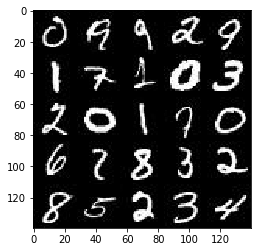

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

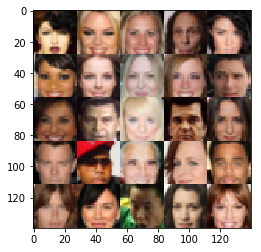

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                           name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = .01
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7*7*256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        alpha = .1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3],
                                                     z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            batch_no = 0
            for batch_images in get_batches(batch_size):
                step += 1
                batch_no += 1
                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if batch_no % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    losses.append((train_loss_d, train_loss_g))
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}...".format(batch_no),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                
                if batch_no % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        fig, ax = pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title("Training Losses")
        pyplot.legend()
        pyplot.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.3016... Generator Loss: 1.5242
Epoch 1/2... Batch 20... Discriminator Loss: 0.3736... Generator Loss: 4.5024
Epoch 1/2... Batch 30... Discriminator Loss: 0.6275... Generator Loss: 1.2137
Epoch 1/2... Batch 40... Discriminator Loss: 0.1892... Generator Loss: 2.2772
Epoch 1/2... Batch 50... Discriminator Loss: 0.1082... Generator Loss: 2.6428
Epoch 1/2... Batch 60... Discriminator Loss: 0.0890... Generator Loss: 3.0644
Epoch 1/2... Batch 70... Discriminator Loss: 7.2777... Generator Loss: 9.2868
Epoch 1/2... Batch 80... Discriminator Loss: 1.7674... Generator Loss: 0.4532
Epoch 1/2... Batch 90... Discriminator Loss: 1.0564... Generator Loss: 1.2006
Epoch 1/2... Batch 100... Discriminator Loss: 1.1684... Generator Loss: 0.9220


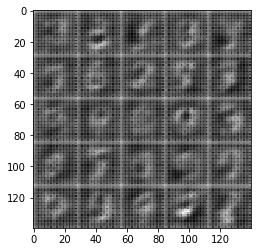

Epoch 1/2... Batch 110... Discriminator Loss: 1.0309... Generator Loss: 0.6657
Epoch 1/2... Batch 120... Discriminator Loss: 1.0233... Generator Loss: 1.3349
Epoch 1/2... Batch 130... Discriminator Loss: 1.3862... Generator Loss: 0.3904
Epoch 1/2... Batch 140... Discriminator Loss: 1.0575... Generator Loss: 0.7800
Epoch 1/2... Batch 150... Discriminator Loss: 0.9820... Generator Loss: 1.0787
Epoch 1/2... Batch 160... Discriminator Loss: 1.0652... Generator Loss: 0.6089
Epoch 1/2... Batch 170... Discriminator Loss: 0.9437... Generator Loss: 0.8015
Epoch 1/2... Batch 180... Discriminator Loss: 0.9905... Generator Loss: 0.8336
Epoch 1/2... Batch 190... Discriminator Loss: 1.0819... Generator Loss: 0.5985
Epoch 1/2... Batch 200... Discriminator Loss: 0.8982... Generator Loss: 1.1014


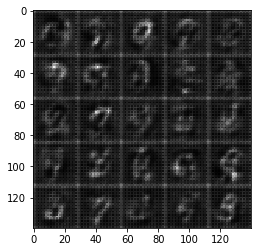

Epoch 1/2... Batch 210... Discriminator Loss: 0.9522... Generator Loss: 0.6346
Epoch 1/2... Batch 220... Discriminator Loss: 0.9745... Generator Loss: 0.8102
Epoch 1/2... Batch 230... Discriminator Loss: 1.1945... Generator Loss: 0.4839
Epoch 1/2... Batch 240... Discriminator Loss: 0.8969... Generator Loss: 1.2172
Epoch 1/2... Batch 250... Discriminator Loss: 0.9390... Generator Loss: 0.9932
Epoch 1/2... Batch 260... Discriminator Loss: 0.9614... Generator Loss: 1.2184
Epoch 1/2... Batch 270... Discriminator Loss: 1.0083... Generator Loss: 0.7866
Epoch 1/2... Batch 280... Discriminator Loss: 0.9286... Generator Loss: 1.4516
Epoch 1/2... Batch 290... Discriminator Loss: 0.8560... Generator Loss: 0.8529
Epoch 1/2... Batch 300... Discriminator Loss: 0.8912... Generator Loss: 1.0623


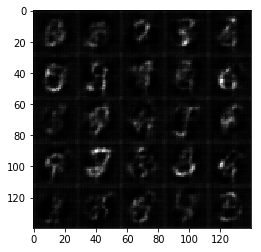

Epoch 1/2... Batch 310... Discriminator Loss: 0.8046... Generator Loss: 1.2348
Epoch 1/2... Batch 320... Discriminator Loss: 0.7694... Generator Loss: 1.2207
Epoch 1/2... Batch 330... Discriminator Loss: 0.8439... Generator Loss: 1.0799
Epoch 1/2... Batch 340... Discriminator Loss: 1.0182... Generator Loss: 0.7982
Epoch 1/2... Batch 350... Discriminator Loss: 0.8298... Generator Loss: 1.4034
Epoch 1/2... Batch 360... Discriminator Loss: 0.8068... Generator Loss: 0.9864
Epoch 1/2... Batch 370... Discriminator Loss: 0.7906... Generator Loss: 1.0426
Epoch 1/2... Batch 380... Discriminator Loss: 1.1204... Generator Loss: 0.5344
Epoch 1/2... Batch 390... Discriminator Loss: 0.8231... Generator Loss: 1.4450
Epoch 1/2... Batch 400... Discriminator Loss: 0.9639... Generator Loss: 0.7112


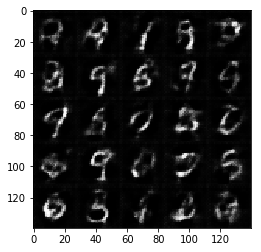

Epoch 1/2... Batch 410... Discriminator Loss: 0.7227... Generator Loss: 1.3016
Epoch 1/2... Batch 420... Discriminator Loss: 0.8903... Generator Loss: 0.8522
Epoch 1/2... Batch 430... Discriminator Loss: 0.6715... Generator Loss: 1.2563
Epoch 1/2... Batch 440... Discriminator Loss: 0.9456... Generator Loss: 0.7223
Epoch 1/2... Batch 450... Discriminator Loss: 0.6919... Generator Loss: 1.4021
Epoch 1/2... Batch 460... Discriminator Loss: 1.0160... Generator Loss: 0.6636
Epoch 1/2... Batch 470... Discriminator Loss: 0.7539... Generator Loss: 1.2293
Epoch 1/2... Batch 480... Discriminator Loss: 0.9497... Generator Loss: 0.8023
Epoch 1/2... Batch 490... Discriminator Loss: 0.8877... Generator Loss: 1.3094
Epoch 1/2... Batch 500... Discriminator Loss: 0.8557... Generator Loss: 1.7666


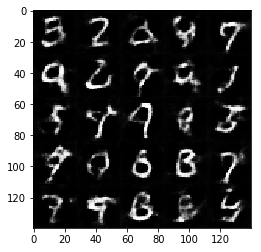

Epoch 1/2... Batch 510... Discriminator Loss: 0.8775... Generator Loss: 1.8748
Epoch 1/2... Batch 520... Discriminator Loss: 0.8548... Generator Loss: 1.0089
Epoch 1/2... Batch 530... Discriminator Loss: 0.8167... Generator Loss: 1.2586
Epoch 1/2... Batch 540... Discriminator Loss: 1.0309... Generator Loss: 0.5953
Epoch 1/2... Batch 550... Discriminator Loss: 0.8361... Generator Loss: 1.0009
Epoch 1/2... Batch 560... Discriminator Loss: 1.0377... Generator Loss: 0.7474
Epoch 1/2... Batch 570... Discriminator Loss: 0.8562... Generator Loss: 1.2011
Epoch 1/2... Batch 580... Discriminator Loss: 0.7292... Generator Loss: 1.5838
Epoch 1/2... Batch 590... Discriminator Loss: 0.8085... Generator Loss: 0.9352
Epoch 1/2... Batch 600... Discriminator Loss: 0.9336... Generator Loss: 1.0490


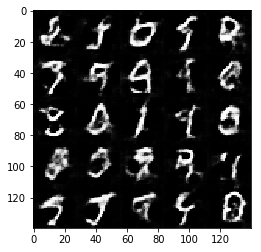

Epoch 1/2... Batch 610... Discriminator Loss: 0.7504... Generator Loss: 1.4993
Epoch 1/2... Batch 620... Discriminator Loss: 0.9934... Generator Loss: 0.6967
Epoch 1/2... Batch 630... Discriminator Loss: 1.3430... Generator Loss: 0.4025
Epoch 1/2... Batch 640... Discriminator Loss: 0.8517... Generator Loss: 1.0992
Epoch 1/2... Batch 650... Discriminator Loss: 0.9614... Generator Loss: 0.7888
Epoch 1/2... Batch 660... Discriminator Loss: 0.8664... Generator Loss: 1.1130
Epoch 1/2... Batch 670... Discriminator Loss: 0.9089... Generator Loss: 1.0106
Epoch 1/2... Batch 680... Discriminator Loss: 0.8471... Generator Loss: 1.1967
Epoch 1/2... Batch 690... Discriminator Loss: 0.8556... Generator Loss: 1.3775
Epoch 1/2... Batch 700... Discriminator Loss: 1.1827... Generator Loss: 0.6197


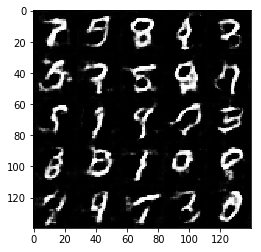

Epoch 1/2... Batch 710... Discriminator Loss: 0.9837... Generator Loss: 0.7305
Epoch 1/2... Batch 720... Discriminator Loss: 0.9972... Generator Loss: 0.6720
Epoch 1/2... Batch 730... Discriminator Loss: 0.9443... Generator Loss: 0.8038
Epoch 1/2... Batch 740... Discriminator Loss: 1.1191... Generator Loss: 1.7878
Epoch 1/2... Batch 750... Discriminator Loss: 0.8507... Generator Loss: 1.2672
Epoch 1/2... Batch 760... Discriminator Loss: 1.0058... Generator Loss: 0.6980
Epoch 1/2... Batch 770... Discriminator Loss: 1.1001... Generator Loss: 0.5564
Epoch 1/2... Batch 780... Discriminator Loss: 0.8429... Generator Loss: 1.4094
Epoch 1/2... Batch 790... Discriminator Loss: 0.8339... Generator Loss: 0.7887
Epoch 1/2... Batch 800... Discriminator Loss: 0.8836... Generator Loss: 1.2474


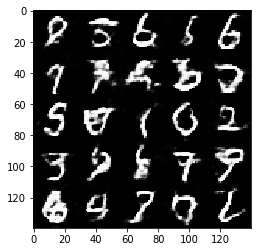

Epoch 1/2... Batch 810... Discriminator Loss: 1.1961... Generator Loss: 0.5147
Epoch 1/2... Batch 820... Discriminator Loss: 0.9620... Generator Loss: 0.7568
Epoch 1/2... Batch 830... Discriminator Loss: 1.0048... Generator Loss: 0.7518
Epoch 1/2... Batch 840... Discriminator Loss: 0.8355... Generator Loss: 1.1187
Epoch 1/2... Batch 850... Discriminator Loss: 1.0274... Generator Loss: 0.7387
Epoch 1/2... Batch 860... Discriminator Loss: 1.2319... Generator Loss: 0.5766
Epoch 1/2... Batch 870... Discriminator Loss: 0.9554... Generator Loss: 0.9556
Epoch 1/2... Batch 880... Discriminator Loss: 0.9605... Generator Loss: 1.0073
Epoch 1/2... Batch 890... Discriminator Loss: 0.8235... Generator Loss: 0.9313
Epoch 1/2... Batch 900... Discriminator Loss: 1.0746... Generator Loss: 0.5876


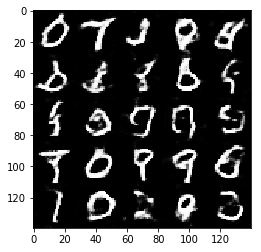

Epoch 1/2... Batch 910... Discriminator Loss: 1.6312... Generator Loss: 0.3114
Epoch 1/2... Batch 920... Discriminator Loss: 1.2400... Generator Loss: 0.4501
Epoch 1/2... Batch 930... Discriminator Loss: 0.9360... Generator Loss: 1.2158
Epoch 1/2... Batch 940... Discriminator Loss: 1.3656... Generator Loss: 0.3800
Epoch 1/2... Batch 950... Discriminator Loss: 1.0146... Generator Loss: 0.6829
Epoch 1/2... Batch 960... Discriminator Loss: 0.9313... Generator Loss: 1.2571
Epoch 1/2... Batch 970... Discriminator Loss: 1.0015... Generator Loss: 1.3649
Epoch 1/2... Batch 980... Discriminator Loss: 0.8759... Generator Loss: 1.6902
Epoch 1/2... Batch 990... Discriminator Loss: 0.8929... Generator Loss: 0.9857
Epoch 1/2... Batch 1000... Discriminator Loss: 0.9252... Generator Loss: 0.8342


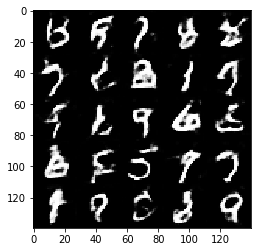

Epoch 1/2... Batch 1010... Discriminator Loss: 1.0403... Generator Loss: 0.6789
Epoch 1/2... Batch 1020... Discriminator Loss: 0.9403... Generator Loss: 0.8142
Epoch 1/2... Batch 1030... Discriminator Loss: 1.0638... Generator Loss: 0.6632
Epoch 1/2... Batch 1040... Discriminator Loss: 1.1234... Generator Loss: 0.5251
Epoch 1/2... Batch 1050... Discriminator Loss: 0.9886... Generator Loss: 0.7024
Epoch 1/2... Batch 1060... Discriminator Loss: 1.0704... Generator Loss: 0.6561
Epoch 1/2... Batch 1070... Discriminator Loss: 1.0056... Generator Loss: 0.7816
Epoch 1/2... Batch 1080... Discriminator Loss: 0.9439... Generator Loss: 0.8002
Epoch 1/2... Batch 1090... Discriminator Loss: 0.6841... Generator Loss: 1.5591
Epoch 1/2... Batch 1100... Discriminator Loss: 0.8116... Generator Loss: 1.1133


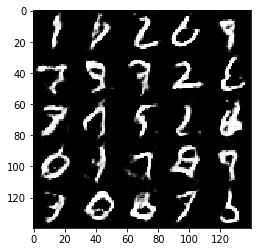

Epoch 1/2... Batch 1110... Discriminator Loss: 1.1725... Generator Loss: 0.5773
Epoch 1/2... Batch 1120... Discriminator Loss: 0.7780... Generator Loss: 1.6938
Epoch 1/2... Batch 1130... Discriminator Loss: 0.7044... Generator Loss: 1.2433
Epoch 1/2... Batch 1140... Discriminator Loss: 0.8624... Generator Loss: 0.7774
Epoch 1/2... Batch 1150... Discriminator Loss: 1.1067... Generator Loss: 0.6697
Epoch 1/2... Batch 1160... Discriminator Loss: 0.9701... Generator Loss: 0.7268
Epoch 1/2... Batch 1170... Discriminator Loss: 0.6873... Generator Loss: 1.1447
Epoch 1/2... Batch 1180... Discriminator Loss: 1.4133... Generator Loss: 0.3832
Epoch 1/2... Batch 1190... Discriminator Loss: 0.9629... Generator Loss: 0.6889
Epoch 1/2... Batch 1200... Discriminator Loss: 0.9867... Generator Loss: 0.6380


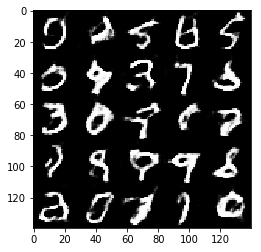

Epoch 1/2... Batch 1210... Discriminator Loss: 0.8797... Generator Loss: 0.9013
Epoch 1/2... Batch 1220... Discriminator Loss: 0.6726... Generator Loss: 1.4039
Epoch 1/2... Batch 1230... Discriminator Loss: 0.7854... Generator Loss: 1.2536
Epoch 1/2... Batch 1240... Discriminator Loss: 0.7022... Generator Loss: 1.4638
Epoch 1/2... Batch 1250... Discriminator Loss: 1.1561... Generator Loss: 0.5434
Epoch 1/2... Batch 1260... Discriminator Loss: 1.2908... Generator Loss: 0.4819
Epoch 1/2... Batch 1270... Discriminator Loss: 0.9094... Generator Loss: 0.7436
Epoch 1/2... Batch 1280... Discriminator Loss: 0.8465... Generator Loss: 0.9386
Epoch 1/2... Batch 1290... Discriminator Loss: 0.9686... Generator Loss: 0.6464
Epoch 1/2... Batch 1300... Discriminator Loss: 0.8198... Generator Loss: 1.5778


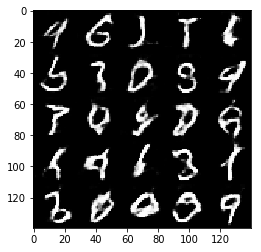

Epoch 1/2... Batch 1310... Discriminator Loss: 0.9532... Generator Loss: 0.7402
Epoch 1/2... Batch 1320... Discriminator Loss: 0.7269... Generator Loss: 0.9815
Epoch 1/2... Batch 1330... Discriminator Loss: 0.8421... Generator Loss: 0.7956
Epoch 1/2... Batch 1340... Discriminator Loss: 0.6643... Generator Loss: 1.3918
Epoch 1/2... Batch 1350... Discriminator Loss: 0.8926... Generator Loss: 0.7380
Epoch 1/2... Batch 1360... Discriminator Loss: 0.8141... Generator Loss: 1.0631
Epoch 1/2... Batch 1370... Discriminator Loss: 0.8944... Generator Loss: 0.7295
Epoch 1/2... Batch 1380... Discriminator Loss: 0.8848... Generator Loss: 0.8179
Epoch 1/2... Batch 1390... Discriminator Loss: 0.7350... Generator Loss: 1.0817
Epoch 1/2... Batch 1400... Discriminator Loss: 0.6589... Generator Loss: 1.3298


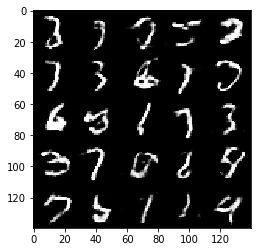

Epoch 1/2... Batch 1410... Discriminator Loss: 1.1251... Generator Loss: 0.5856
Epoch 1/2... Batch 1420... Discriminator Loss: 0.7842... Generator Loss: 0.9131
Epoch 1/2... Batch 1430... Discriminator Loss: 0.7652... Generator Loss: 1.0239
Epoch 1/2... Batch 1440... Discriminator Loss: 0.9016... Generator Loss: 0.8509
Epoch 1/2... Batch 1450... Discriminator Loss: 0.9816... Generator Loss: 0.6619
Epoch 1/2... Batch 1460... Discriminator Loss: 1.0394... Generator Loss: 0.6657
Epoch 1/2... Batch 1470... Discriminator Loss: 0.7191... Generator Loss: 1.2838
Epoch 1/2... Batch 1480... Discriminator Loss: 3.9454... Generator Loss: 0.0324
Epoch 1/2... Batch 1490... Discriminator Loss: 0.7808... Generator Loss: 1.3406
Epoch 1/2... Batch 1500... Discriminator Loss: 0.7451... Generator Loss: 1.3698


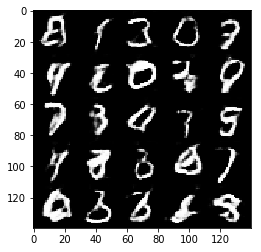

Epoch 1/2... Batch 1510... Discriminator Loss: 0.8873... Generator Loss: 0.8952
Epoch 1/2... Batch 1520... Discriminator Loss: 1.1837... Generator Loss: 0.5022
Epoch 1/2... Batch 1530... Discriminator Loss: 0.8649... Generator Loss: 0.9172
Epoch 1/2... Batch 1540... Discriminator Loss: 1.1474... Generator Loss: 0.5289
Epoch 1/2... Batch 1550... Discriminator Loss: 1.0305... Generator Loss: 0.7501
Epoch 1/2... Batch 1560... Discriminator Loss: 0.7040... Generator Loss: 1.1652
Epoch 1/2... Batch 1570... Discriminator Loss: 0.7414... Generator Loss: 0.9084
Epoch 1/2... Batch 1580... Discriminator Loss: 0.6064... Generator Loss: 1.3881
Epoch 1/2... Batch 1590... Discriminator Loss: 0.8352... Generator Loss: 0.9182
Epoch 1/2... Batch 1600... Discriminator Loss: 0.8288... Generator Loss: 0.8640


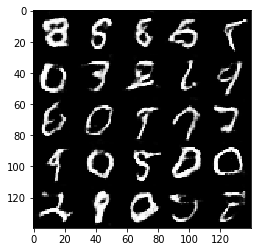

Epoch 1/2... Batch 1610... Discriminator Loss: 0.6939... Generator Loss: 1.2856
Epoch 1/2... Batch 1620... Discriminator Loss: 0.7683... Generator Loss: 0.9853
Epoch 1/2... Batch 1630... Discriminator Loss: 0.8971... Generator Loss: 1.4517
Epoch 1/2... Batch 1640... Discriminator Loss: 0.9478... Generator Loss: 0.6782
Epoch 1/2... Batch 1650... Discriminator Loss: 0.5943... Generator Loss: 1.8387
Epoch 1/2... Batch 1660... Discriminator Loss: 2.5604... Generator Loss: 3.6035
Epoch 1/2... Batch 1670... Discriminator Loss: 0.5962... Generator Loss: 1.4861
Epoch 1/2... Batch 1680... Discriminator Loss: 0.9115... Generator Loss: 0.8197
Epoch 1/2... Batch 1690... Discriminator Loss: 0.8126... Generator Loss: 0.9845
Epoch 1/2... Batch 1700... Discriminator Loss: 0.7383... Generator Loss: 1.6914


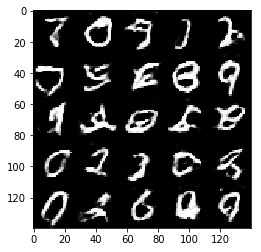

Epoch 1/2... Batch 1710... Discriminator Loss: 0.9074... Generator Loss: 0.7613
Epoch 1/2... Batch 1720... Discriminator Loss: 0.9300... Generator Loss: 0.7470
Epoch 1/2... Batch 1730... Discriminator Loss: 0.5909... Generator Loss: 1.5014
Epoch 1/2... Batch 1740... Discriminator Loss: 0.7869... Generator Loss: 1.0424
Epoch 1/2... Batch 1750... Discriminator Loss: 0.8294... Generator Loss: 0.7520
Epoch 1/2... Batch 1760... Discriminator Loss: 0.9688... Generator Loss: 0.6315
Epoch 1/2... Batch 1770... Discriminator Loss: 0.8541... Generator Loss: 1.1957
Epoch 1/2... Batch 1780... Discriminator Loss: 0.9750... Generator Loss: 0.7254
Epoch 1/2... Batch 1790... Discriminator Loss: 0.7284... Generator Loss: 1.0916
Epoch 1/2... Batch 1800... Discriminator Loss: 0.9833... Generator Loss: 0.7740


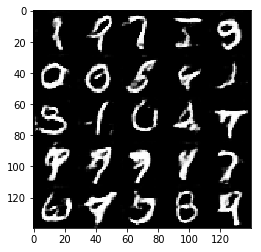

Epoch 1/2... Batch 1810... Discriminator Loss: 0.6867... Generator Loss: 1.3822
Epoch 1/2... Batch 1820... Discriminator Loss: 0.8834... Generator Loss: 0.8771
Epoch 1/2... Batch 1830... Discriminator Loss: 0.7921... Generator Loss: 0.8392
Epoch 1/2... Batch 1840... Discriminator Loss: 0.7209... Generator Loss: 1.1148
Epoch 1/2... Batch 1850... Discriminator Loss: 0.8461... Generator Loss: 0.9415
Epoch 1/2... Batch 1860... Discriminator Loss: 0.5788... Generator Loss: 1.3586
Epoch 1/2... Batch 1870... Discriminator Loss: 0.6517... Generator Loss: 1.5108
Epoch 2/2... Batch 10... Discriminator Loss: 0.5200... Generator Loss: 1.2677
Epoch 2/2... Batch 20... Discriminator Loss: 0.6160... Generator Loss: 1.9447
Epoch 2/2... Batch 30... Discriminator Loss: 0.7755... Generator Loss: 1.1051
Epoch 2/2... Batch 40... Discriminator Loss: 0.5853... Generator Loss: 1.2851
Epoch 2/2... Batch 50... Discriminator Loss: 1.8405... Generator Loss: 2.9081
Epoch 2/2... Batch 60... Discriminator Loss: 1.209

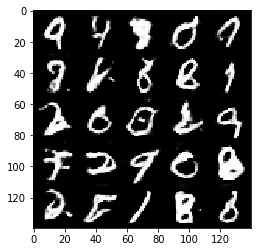

Epoch 2/2... Batch 110... Discriminator Loss: 0.9777... Generator Loss: 0.6058
Epoch 2/2... Batch 120... Discriminator Loss: 1.0759... Generator Loss: 0.5443
Epoch 2/2... Batch 130... Discriminator Loss: 1.2379... Generator Loss: 0.4841
Epoch 2/2... Batch 140... Discriminator Loss: 0.7692... Generator Loss: 1.0467
Epoch 2/2... Batch 150... Discriminator Loss: 1.2328... Generator Loss: 0.5197
Epoch 2/2... Batch 160... Discriminator Loss: 0.6736... Generator Loss: 1.0841
Epoch 2/2... Batch 170... Discriminator Loss: 0.5662... Generator Loss: 1.2400
Epoch 2/2... Batch 180... Discriminator Loss: 0.6895... Generator Loss: 1.0529
Epoch 2/2... Batch 190... Discriminator Loss: 0.8519... Generator Loss: 0.8101
Epoch 2/2... Batch 200... Discriminator Loss: 0.5381... Generator Loss: 1.3717


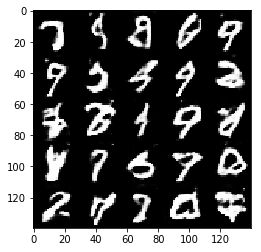

Epoch 2/2... Batch 210... Discriminator Loss: 0.5033... Generator Loss: 1.7783
Epoch 2/2... Batch 220... Discriminator Loss: 0.6120... Generator Loss: 1.2609
Epoch 2/2... Batch 230... Discriminator Loss: 0.7043... Generator Loss: 1.0980
Epoch 2/2... Batch 240... Discriminator Loss: 0.5220... Generator Loss: 1.4314
Epoch 2/2... Batch 250... Discriminator Loss: 0.6549... Generator Loss: 1.4855
Epoch 2/2... Batch 260... Discriminator Loss: 0.5310... Generator Loss: 2.0671
Epoch 2/2... Batch 270... Discriminator Loss: 0.7295... Generator Loss: 1.9328
Epoch 2/2... Batch 280... Discriminator Loss: 0.7383... Generator Loss: 1.1133
Epoch 2/2... Batch 290... Discriminator Loss: 0.8783... Generator Loss: 0.8778
Epoch 2/2... Batch 300... Discriminator Loss: 0.8898... Generator Loss: 0.7660


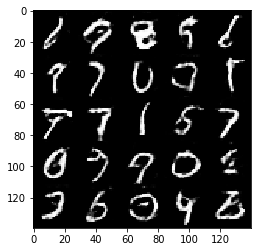

Epoch 2/2... Batch 310... Discriminator Loss: 0.9186... Generator Loss: 0.7107
Epoch 2/2... Batch 320... Discriminator Loss: 0.5068... Generator Loss: 1.8477
Epoch 2/2... Batch 330... Discriminator Loss: 0.7041... Generator Loss: 1.0947
Epoch 2/2... Batch 340... Discriminator Loss: 1.3286... Generator Loss: 0.4947
Epoch 2/2... Batch 350... Discriminator Loss: 0.5624... Generator Loss: 1.2555
Epoch 2/2... Batch 360... Discriminator Loss: 0.7776... Generator Loss: 0.8550
Epoch 2/2... Batch 370... Discriminator Loss: 0.6237... Generator Loss: 1.1403
Epoch 2/2... Batch 380... Discriminator Loss: 0.6210... Generator Loss: 1.1200
Epoch 2/2... Batch 390... Discriminator Loss: 0.7343... Generator Loss: 0.9453
Epoch 2/2... Batch 400... Discriminator Loss: 0.5639... Generator Loss: 1.2609


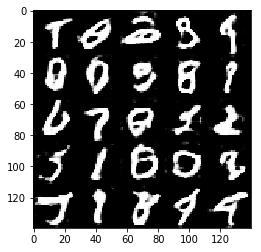

Epoch 2/2... Batch 410... Discriminator Loss: 0.7744... Generator Loss: 1.0599
Epoch 2/2... Batch 420... Discriminator Loss: 0.6664... Generator Loss: 1.1249
Epoch 2/2... Batch 430... Discriminator Loss: 0.6947... Generator Loss: 1.0998
Epoch 2/2... Batch 440... Discriminator Loss: 0.5811... Generator Loss: 1.4368
Epoch 2/2... Batch 450... Discriminator Loss: 0.8398... Generator Loss: 1.0199
Epoch 2/2... Batch 460... Discriminator Loss: 0.7622... Generator Loss: 0.9144
Epoch 2/2... Batch 470... Discriminator Loss: 0.4243... Generator Loss: 1.6018
Epoch 2/2... Batch 480... Discriminator Loss: 0.5980... Generator Loss: 1.0795
Epoch 2/2... Batch 490... Discriminator Loss: 0.5542... Generator Loss: 1.0807
Epoch 2/2... Batch 500... Discriminator Loss: 0.5760... Generator Loss: 1.1627


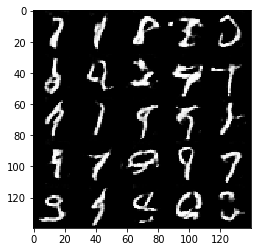

Epoch 2/2... Batch 510... Discriminator Loss: 0.4959... Generator Loss: 1.4607
Epoch 2/2... Batch 520... Discriminator Loss: 0.7777... Generator Loss: 0.9882
Epoch 2/2... Batch 530... Discriminator Loss: 0.5433... Generator Loss: 1.6420
Epoch 2/2... Batch 540... Discriminator Loss: 0.5443... Generator Loss: 1.2852
Epoch 2/2... Batch 550... Discriminator Loss: 1.0746... Generator Loss: 3.0637
Epoch 2/2... Batch 560... Discriminator Loss: 0.8729... Generator Loss: 0.9769
Epoch 2/2... Batch 570... Discriminator Loss: 0.7233... Generator Loss: 0.8832
Epoch 2/2... Batch 580... Discriminator Loss: 0.5225... Generator Loss: 1.4481
Epoch 2/2... Batch 590... Discriminator Loss: 0.4908... Generator Loss: 1.5844
Epoch 2/2... Batch 600... Discriminator Loss: 0.9649... Generator Loss: 0.6320


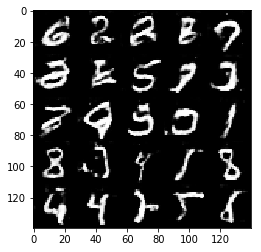

Epoch 2/2... Batch 610... Discriminator Loss: 0.7145... Generator Loss: 1.0074
Epoch 2/2... Batch 620... Discriminator Loss: 0.7226... Generator Loss: 0.9720
Epoch 2/2... Batch 630... Discriminator Loss: 0.5816... Generator Loss: 1.2299
Epoch 2/2... Batch 640... Discriminator Loss: 0.4976... Generator Loss: 1.5837
Epoch 2/2... Batch 650... Discriminator Loss: 0.4611... Generator Loss: 1.9398
Epoch 2/2... Batch 660... Discriminator Loss: 0.5145... Generator Loss: 1.6155
Epoch 2/2... Batch 670... Discriminator Loss: 0.8675... Generator Loss: 0.8300
Epoch 2/2... Batch 680... Discriminator Loss: 0.7095... Generator Loss: 0.9377
Epoch 2/2... Batch 690... Discriminator Loss: 0.7353... Generator Loss: 1.2188
Epoch 2/2... Batch 700... Discriminator Loss: 1.1199... Generator Loss: 0.6060


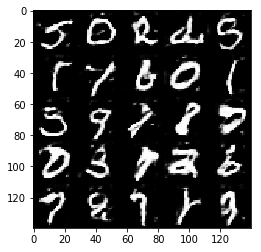

Epoch 2/2... Batch 710... Discriminator Loss: 0.7255... Generator Loss: 1.2159
Epoch 2/2... Batch 720... Discriminator Loss: 0.7185... Generator Loss: 1.0652
Epoch 2/2... Batch 730... Discriminator Loss: 0.6801... Generator Loss: 0.9968
Epoch 2/2... Batch 740... Discriminator Loss: 0.5743... Generator Loss: 1.3227
Epoch 2/2... Batch 750... Discriminator Loss: 0.5442... Generator Loss: 1.6926
Epoch 2/2... Batch 760... Discriminator Loss: 0.4494... Generator Loss: 1.5292
Epoch 2/2... Batch 770... Discriminator Loss: 0.9493... Generator Loss: 0.6494
Epoch 2/2... Batch 780... Discriminator Loss: 0.4691... Generator Loss: 1.5190
Epoch 2/2... Batch 790... Discriminator Loss: 0.5799... Generator Loss: 1.1586
Epoch 2/2... Batch 800... Discriminator Loss: 0.5736... Generator Loss: 1.2874


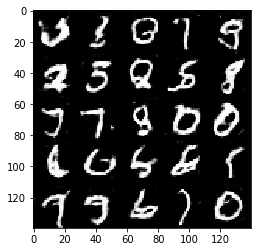

Epoch 2/2... Batch 810... Discriminator Loss: 0.9407... Generator Loss: 0.7233
Epoch 2/2... Batch 820... Discriminator Loss: 0.5333... Generator Loss: 1.5238
Epoch 2/2... Batch 830... Discriminator Loss: 0.9175... Generator Loss: 0.6316
Epoch 2/2... Batch 840... Discriminator Loss: 0.5690... Generator Loss: 1.2579
Epoch 2/2... Batch 850... Discriminator Loss: 0.6484... Generator Loss: 1.0158
Epoch 2/2... Batch 860... Discriminator Loss: 0.4151... Generator Loss: 1.4293
Epoch 2/2... Batch 870... Discriminator Loss: 0.7874... Generator Loss: 0.9681
Epoch 2/2... Batch 880... Discriminator Loss: 0.6372... Generator Loss: 1.1194
Epoch 2/2... Batch 890... Discriminator Loss: 0.8355... Generator Loss: 0.8244
Epoch 2/2... Batch 900... Discriminator Loss: 0.6794... Generator Loss: 0.8827


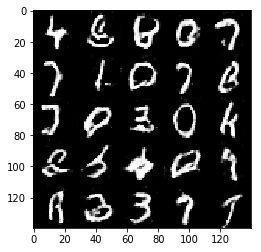

Epoch 2/2... Batch 910... Discriminator Loss: 0.6613... Generator Loss: 0.9737
Epoch 2/2... Batch 920... Discriminator Loss: 0.9774... Generator Loss: 0.5968
Epoch 2/2... Batch 930... Discriminator Loss: 0.9155... Generator Loss: 0.6620
Epoch 2/2... Batch 940... Discriminator Loss: 0.9809... Generator Loss: 0.6502
Epoch 2/2... Batch 950... Discriminator Loss: 0.7739... Generator Loss: 0.9625
Epoch 2/2... Batch 960... Discriminator Loss: 1.0906... Generator Loss: 0.6888
Epoch 2/2... Batch 970... Discriminator Loss: 0.6421... Generator Loss: 1.5070
Epoch 2/2... Batch 980... Discriminator Loss: 0.7326... Generator Loss: 0.9756
Epoch 2/2... Batch 990... Discriminator Loss: 0.6670... Generator Loss: 1.1466
Epoch 2/2... Batch 1000... Discriminator Loss: 0.8156... Generator Loss: 0.8150


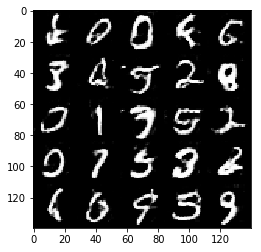

Epoch 2/2... Batch 1010... Discriminator Loss: 0.7711... Generator Loss: 0.9045
Epoch 2/2... Batch 1020... Discriminator Loss: 0.6304... Generator Loss: 1.0817
Epoch 2/2... Batch 1030... Discriminator Loss: 0.7160... Generator Loss: 0.9812
Epoch 2/2... Batch 1040... Discriminator Loss: 0.6372... Generator Loss: 1.0671
Epoch 2/2... Batch 1050... Discriminator Loss: 0.5268... Generator Loss: 1.2449
Epoch 2/2... Batch 1060... Discriminator Loss: 0.5323... Generator Loss: 1.2821
Epoch 2/2... Batch 1070... Discriminator Loss: 0.6812... Generator Loss: 2.2560
Epoch 2/2... Batch 1080... Discriminator Loss: 0.6815... Generator Loss: 0.9639
Epoch 2/2... Batch 1090... Discriminator Loss: 0.4755... Generator Loss: 1.5147
Epoch 2/2... Batch 1100... Discriminator Loss: 1.0939... Generator Loss: 0.6861


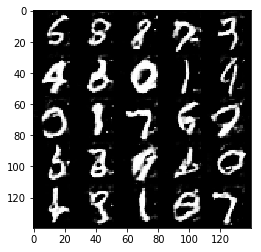

Epoch 2/2... Batch 1110... Discriminator Loss: 0.6388... Generator Loss: 1.6198
Epoch 2/2... Batch 1120... Discriminator Loss: 0.4592... Generator Loss: 1.9176
Epoch 2/2... Batch 1130... Discriminator Loss: 0.5640... Generator Loss: 1.3301
Epoch 2/2... Batch 1140... Discriminator Loss: 0.5316... Generator Loss: 1.5123
Epoch 2/2... Batch 1150... Discriminator Loss: 1.0838... Generator Loss: 0.5607
Epoch 2/2... Batch 1160... Discriminator Loss: 0.4851... Generator Loss: 1.4565
Epoch 2/2... Batch 1170... Discriminator Loss: 0.6546... Generator Loss: 1.0370
Epoch 2/2... Batch 1180... Discriminator Loss: 1.2717... Generator Loss: 0.4739
Epoch 2/2... Batch 1190... Discriminator Loss: 0.7293... Generator Loss: 1.0161
Epoch 2/2... Batch 1200... Discriminator Loss: 0.5504... Generator Loss: 1.4971


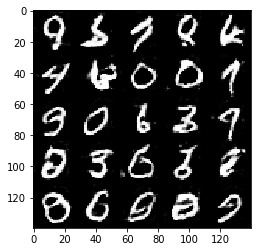

Epoch 2/2... Batch 1210... Discriminator Loss: 0.8200... Generator Loss: 0.8224
Epoch 2/2... Batch 1220... Discriminator Loss: 0.5717... Generator Loss: 1.3800
Epoch 2/2... Batch 1230... Discriminator Loss: 0.4858... Generator Loss: 1.5924
Epoch 2/2... Batch 1240... Discriminator Loss: 0.6312... Generator Loss: 1.1923
Epoch 2/2... Batch 1250... Discriminator Loss: 0.7172... Generator Loss: 1.0499
Epoch 2/2... Batch 1260... Discriminator Loss: 0.6010... Generator Loss: 1.1626
Epoch 2/2... Batch 1270... Discriminator Loss: 0.6673... Generator Loss: 1.2054
Epoch 2/2... Batch 1280... Discriminator Loss: 0.7164... Generator Loss: 0.9395
Epoch 2/2... Batch 1290... Discriminator Loss: 0.7034... Generator Loss: 1.0207
Epoch 2/2... Batch 1300... Discriminator Loss: 0.5621... Generator Loss: 1.4518


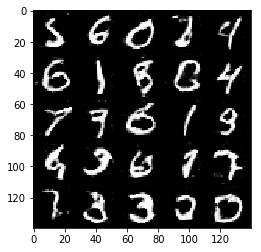

Epoch 2/2... Batch 1310... Discriminator Loss: 0.7200... Generator Loss: 1.1950
Epoch 2/2... Batch 1320... Discriminator Loss: 0.6581... Generator Loss: 0.9835
Epoch 2/2... Batch 1330... Discriminator Loss: 0.6519... Generator Loss: 1.3080
Epoch 2/2... Batch 1340... Discriminator Loss: 0.9316... Generator Loss: 0.7482
Epoch 2/2... Batch 1350... Discriminator Loss: 0.8824... Generator Loss: 0.8704
Epoch 2/2... Batch 1360... Discriminator Loss: 1.5734... Generator Loss: 3.1362
Epoch 2/2... Batch 1370... Discriminator Loss: 0.7580... Generator Loss: 0.9389
Epoch 2/2... Batch 1380... Discriminator Loss: 0.6942... Generator Loss: 1.1535
Epoch 2/2... Batch 1390... Discriminator Loss: 0.4683... Generator Loss: 1.6883
Epoch 2/2... Batch 1400... Discriminator Loss: 0.6459... Generator Loss: 1.2243


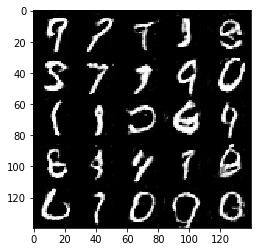

Epoch 2/2... Batch 1410... Discriminator Loss: 0.8891... Generator Loss: 0.7351
Epoch 2/2... Batch 1420... Discriminator Loss: 1.3846... Generator Loss: 0.7593
Epoch 2/2... Batch 1430... Discriminator Loss: 1.1933... Generator Loss: 0.6055
Epoch 2/2... Batch 1440... Discriminator Loss: 0.9589... Generator Loss: 0.7552
Epoch 2/2... Batch 1450... Discriminator Loss: 1.0064... Generator Loss: 0.6982
Epoch 2/2... Batch 1460... Discriminator Loss: 0.6211... Generator Loss: 1.7875
Epoch 2/2... Batch 1470... Discriminator Loss: 1.0004... Generator Loss: 2.7625
Epoch 2/2... Batch 1480... Discriminator Loss: 0.6253... Generator Loss: 1.7796
Epoch 2/2... Batch 1490... Discriminator Loss: 0.6180... Generator Loss: 1.4206
Epoch 2/2... Batch 1500... Discriminator Loss: 0.7006... Generator Loss: 0.9668


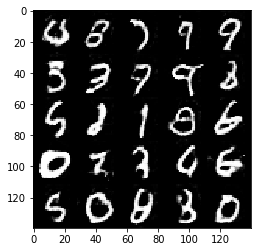

Epoch 2/2... Batch 1510... Discriminator Loss: 0.6856... Generator Loss: 0.9762
Epoch 2/2... Batch 1520... Discriminator Loss: 0.8320... Generator Loss: 0.9320
Epoch 2/2... Batch 1530... Discriminator Loss: 0.6385... Generator Loss: 1.1051
Epoch 2/2... Batch 1540... Discriminator Loss: 0.6730... Generator Loss: 1.1292
Epoch 2/2... Batch 1550... Discriminator Loss: 0.7060... Generator Loss: 1.2040
Epoch 2/2... Batch 1560... Discriminator Loss: 0.8367... Generator Loss: 0.8439
Epoch 2/2... Batch 1570... Discriminator Loss: 1.0027... Generator Loss: 0.6493
Epoch 2/2... Batch 1580... Discriminator Loss: 0.5014... Generator Loss: 1.2869
Epoch 2/2... Batch 1590... Discriminator Loss: 0.6227... Generator Loss: 1.5912
Epoch 2/2... Batch 1600... Discriminator Loss: 0.8379... Generator Loss: 0.6941


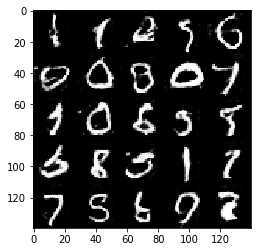

Epoch 2/2... Batch 1610... Discriminator Loss: 0.6122... Generator Loss: 1.5202
Epoch 2/2... Batch 1620... Discriminator Loss: 0.3548... Generator Loss: 2.0828
Epoch 2/2... Batch 1630... Discriminator Loss: 0.6873... Generator Loss: 1.4813
Epoch 2/2... Batch 1640... Discriminator Loss: 0.5878... Generator Loss: 1.2841
Epoch 2/2... Batch 1650... Discriminator Loss: 0.4594... Generator Loss: 1.6906
Epoch 2/2... Batch 1660... Discriminator Loss: 0.4964... Generator Loss: 1.5838
Epoch 2/2... Batch 1670... Discriminator Loss: 0.4684... Generator Loss: 1.6259
Epoch 2/2... Batch 1680... Discriminator Loss: 0.9398... Generator Loss: 0.7187
Epoch 2/2... Batch 1690... Discriminator Loss: 1.0360... Generator Loss: 0.6972
Epoch 2/2... Batch 1700... Discriminator Loss: 0.6288... Generator Loss: 1.2410


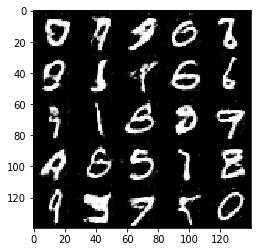

Epoch 2/2... Batch 1710... Discriminator Loss: 0.6126... Generator Loss: 1.1438
Epoch 2/2... Batch 1720... Discriminator Loss: 0.9546... Generator Loss: 0.6654
Epoch 2/2... Batch 1730... Discriminator Loss: 0.5659... Generator Loss: 1.4124
Epoch 2/2... Batch 1740... Discriminator Loss: 0.5293... Generator Loss: 1.5342
Epoch 2/2... Batch 1750... Discriminator Loss: 0.9956... Generator Loss: 0.6773
Epoch 2/2... Batch 1760... Discriminator Loss: 1.0408... Generator Loss: 0.7598
Epoch 2/2... Batch 1770... Discriminator Loss: 0.7262... Generator Loss: 1.5031
Epoch 2/2... Batch 1780... Discriminator Loss: 0.7301... Generator Loss: 1.3952
Epoch 2/2... Batch 1790... Discriminator Loss: 0.8756... Generator Loss: 1.8830
Epoch 2/2... Batch 1800... Discriminator Loss: 0.8173... Generator Loss: 0.8614


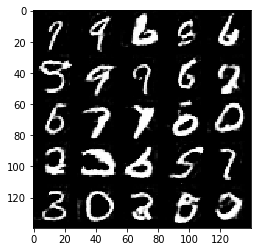

Epoch 2/2... Batch 1810... Discriminator Loss: 0.6479... Generator Loss: 1.2626
Epoch 2/2... Batch 1820... Discriminator Loss: 1.0344... Generator Loss: 2.9434
Epoch 2/2... Batch 1830... Discriminator Loss: 0.5920... Generator Loss: 1.6688
Epoch 2/2... Batch 1840... Discriminator Loss: 0.6643... Generator Loss: 1.3657
Epoch 2/2... Batch 1850... Discriminator Loss: 0.6660... Generator Loss: 1.1739
Epoch 2/2... Batch 1860... Discriminator Loss: 0.7630... Generator Loss: 0.8898
Epoch 2/2... Batch 1870... Discriminator Loss: 0.8625... Generator Loss: 1.9267


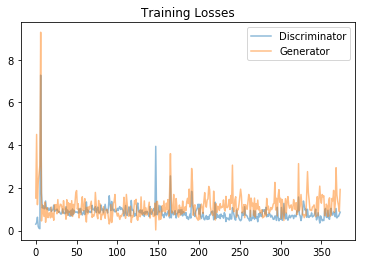

In [26]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.0158... Generator Loss: 5.9071
Epoch 1/1... Batch 20... Discriminator Loss: 0.0278... Generator Loss: 9.0059
Epoch 1/1... Batch 30... Discriminator Loss: 0.0104... Generator Loss: 5.1711
Epoch 1/1... Batch 40... Discriminator Loss: 2.1274... Generator Loss: 7.7485
Epoch 1/1... Batch 50... Discriminator Loss: 0.7387... Generator Loss: 2.8431
Epoch 1/1... Batch 60... Discriminator Loss: 1.0457... Generator Loss: 6.5210
Epoch 1/1... Batch 70... Discriminator Loss: 0.2012... Generator Loss: 3.7891
Epoch 1/1... Batch 80... Discriminator Loss: 0.7156... Generator Loss: 1.9959
Epoch 1/1... Batch 90... Discriminator Loss: 0.8376... Generator Loss: 1.5252
Epoch 1/1... Batch 100... Discriminator Loss: 1.7350... Generator Loss: 2.4328


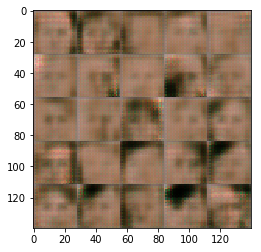

Epoch 1/1... Batch 110... Discriminator Loss: 1.6305... Generator Loss: 0.9384
Epoch 1/1... Batch 120... Discriminator Loss: 0.5648... Generator Loss: 1.9927
Epoch 1/1... Batch 130... Discriminator Loss: 0.9954... Generator Loss: 0.8648
Epoch 1/1... Batch 140... Discriminator Loss: 1.1264... Generator Loss: 0.6032
Epoch 1/1... Batch 150... Discriminator Loss: 0.5798... Generator Loss: 3.0493
Epoch 1/1... Batch 160... Discriminator Loss: 1.0675... Generator Loss: 1.1662
Epoch 1/1... Batch 170... Discriminator Loss: 1.4853... Generator Loss: 0.3946
Epoch 1/1... Batch 180... Discriminator Loss: 0.6767... Generator Loss: 2.6361
Epoch 1/1... Batch 190... Discriminator Loss: 0.3088... Generator Loss: 2.0958
Epoch 1/1... Batch 200... Discriminator Loss: 2.2323... Generator Loss: 3.3712


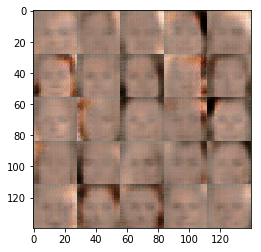

Epoch 1/1... Batch 210... Discriminator Loss: 1.6442... Generator Loss: 1.9321
Epoch 1/1... Batch 220... Discriminator Loss: 0.7681... Generator Loss: 3.2219
Epoch 1/1... Batch 230... Discriminator Loss: 1.4150... Generator Loss: 0.4310
Epoch 1/1... Batch 240... Discriminator Loss: 1.2580... Generator Loss: 1.2416
Epoch 1/1... Batch 250... Discriminator Loss: 0.7380... Generator Loss: 1.2605
Epoch 1/1... Batch 260... Discriminator Loss: 2.6281... Generator Loss: 0.1292
Epoch 1/1... Batch 270... Discriminator Loss: 1.3899... Generator Loss: 1.9220
Epoch 1/1... Batch 280... Discriminator Loss: 1.6732... Generator Loss: 0.2940
Epoch 1/1... Batch 290... Discriminator Loss: 2.1966... Generator Loss: 0.1812
Epoch 1/1... Batch 300... Discriminator Loss: 1.4008... Generator Loss: 4.1625


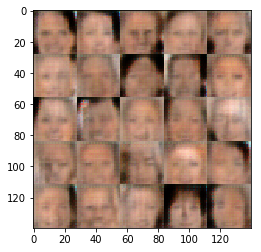

Epoch 1/1... Batch 310... Discriminator Loss: 1.2237... Generator Loss: 2.4726
Epoch 1/1... Batch 320... Discriminator Loss: 1.6585... Generator Loss: 1.7839
Epoch 1/1... Batch 330... Discriminator Loss: 1.1028... Generator Loss: 0.6325
Epoch 1/1... Batch 340... Discriminator Loss: 0.8116... Generator Loss: 1.2459
Epoch 1/1... Batch 350... Discriminator Loss: 1.2415... Generator Loss: 4.4441
Epoch 1/1... Batch 360... Discriminator Loss: 1.0430... Generator Loss: 1.0964
Epoch 1/1... Batch 370... Discriminator Loss: 1.2643... Generator Loss: 0.5158
Epoch 1/1... Batch 380... Discriminator Loss: 0.9446... Generator Loss: 0.8906
Epoch 1/1... Batch 390... Discriminator Loss: 1.3089... Generator Loss: 0.5366
Epoch 1/1... Batch 400... Discriminator Loss: 0.1551... Generator Loss: 3.6505


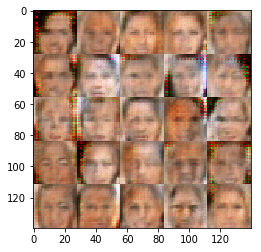

Epoch 1/1... Batch 410... Discriminator Loss: 1.2112... Generator Loss: 0.4728
Epoch 1/1... Batch 420... Discriminator Loss: 4.6134... Generator Loss: 4.0466
Epoch 1/1... Batch 430... Discriminator Loss: 1.7354... Generator Loss: 1.7216
Epoch 1/1... Batch 440... Discriminator Loss: 0.3849... Generator Loss: 1.9972
Epoch 1/1... Batch 450... Discriminator Loss: 0.6478... Generator Loss: 1.7041
Epoch 1/1... Batch 460... Discriminator Loss: 0.9295... Generator Loss: 0.9254
Epoch 1/1... Batch 470... Discriminator Loss: 1.2624... Generator Loss: 0.5328
Epoch 1/1... Batch 480... Discriminator Loss: 2.4014... Generator Loss: 0.1228
Epoch 1/1... Batch 490... Discriminator Loss: 1.5044... Generator Loss: 0.3337
Epoch 1/1... Batch 500... Discriminator Loss: 1.3223... Generator Loss: 0.8462


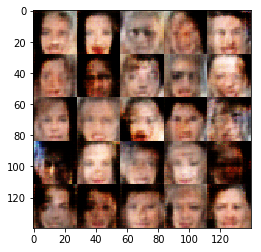

Epoch 1/1... Batch 510... Discriminator Loss: 0.3847... Generator Loss: 6.4038
Epoch 1/1... Batch 520... Discriminator Loss: 1.4385... Generator Loss: 0.4336
Epoch 1/1... Batch 530... Discriminator Loss: 1.2514... Generator Loss: 0.6628
Epoch 1/1... Batch 540... Discriminator Loss: 0.9793... Generator Loss: 0.7769
Epoch 1/1... Batch 550... Discriminator Loss: 1.0057... Generator Loss: 0.7399
Epoch 1/1... Batch 560... Discriminator Loss: 0.5990... Generator Loss: 4.2030
Epoch 1/1... Batch 570... Discriminator Loss: 0.8585... Generator Loss: 0.9298
Epoch 1/1... Batch 580... Discriminator Loss: 1.7499... Generator Loss: 0.2789
Epoch 1/1... Batch 590... Discriminator Loss: 2.2711... Generator Loss: 0.1320
Epoch 1/1... Batch 600... Discriminator Loss: 1.1337... Generator Loss: 0.8210


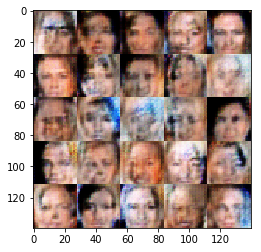

Epoch 1/1... Batch 610... Discriminator Loss: 1.3130... Generator Loss: 0.4167
Epoch 1/1... Batch 620... Discriminator Loss: 1.3311... Generator Loss: 0.5154
Epoch 1/1... Batch 630... Discriminator Loss: 0.7665... Generator Loss: 0.9999
Epoch 1/1... Batch 640... Discriminator Loss: 0.9437... Generator Loss: 0.6551
Epoch 1/1... Batch 650... Discriminator Loss: 1.0106... Generator Loss: 1.7624
Epoch 1/1... Batch 660... Discriminator Loss: 1.3970... Generator Loss: 1.6919
Epoch 1/1... Batch 670... Discriminator Loss: 1.2322... Generator Loss: 0.6649
Epoch 1/1... Batch 680... Discriminator Loss: 1.4732... Generator Loss: 0.3902
Epoch 1/1... Batch 690... Discriminator Loss: 2.8285... Generator Loss: 0.0965
Epoch 1/1... Batch 700... Discriminator Loss: 1.5297... Generator Loss: 0.3270


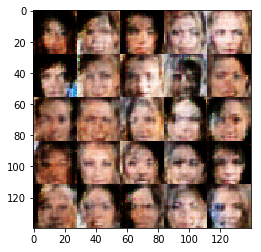

Epoch 1/1... Batch 710... Discriminator Loss: 0.9017... Generator Loss: 2.4817
Epoch 1/1... Batch 720... Discriminator Loss: 2.2016... Generator Loss: 4.2618
Epoch 1/1... Batch 730... Discriminator Loss: 1.1998... Generator Loss: 1.2975
Epoch 1/1... Batch 740... Discriminator Loss: 1.2978... Generator Loss: 2.0758
Epoch 1/1... Batch 750... Discriminator Loss: 0.9529... Generator Loss: 0.7193
Epoch 1/1... Batch 760... Discriminator Loss: 1.2571... Generator Loss: 1.8816
Epoch 1/1... Batch 770... Discriminator Loss: 0.9967... Generator Loss: 0.8547
Epoch 1/1... Batch 780... Discriminator Loss: 1.2452... Generator Loss: 0.7620
Epoch 1/1... Batch 790... Discriminator Loss: 1.0997... Generator Loss: 0.6122
Epoch 1/1... Batch 800... Discriminator Loss: 1.0134... Generator Loss: 1.6250


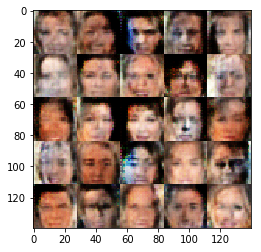

Epoch 1/1... Batch 810... Discriminator Loss: 1.3258... Generator Loss: 0.4415
Epoch 1/1... Batch 820... Discriminator Loss: 1.1192... Generator Loss: 0.7440
Epoch 1/1... Batch 830... Discriminator Loss: 1.3157... Generator Loss: 0.5738
Epoch 1/1... Batch 840... Discriminator Loss: 0.9050... Generator Loss: 0.8133
Epoch 1/1... Batch 850... Discriminator Loss: 2.1938... Generator Loss: 0.1535
Epoch 1/1... Batch 860... Discriminator Loss: 0.9816... Generator Loss: 0.7779
Epoch 1/1... Batch 870... Discriminator Loss: 1.8705... Generator Loss: 5.1485
Epoch 1/1... Batch 880... Discriminator Loss: 1.1847... Generator Loss: 0.5942
Epoch 1/1... Batch 890... Discriminator Loss: 1.6689... Generator Loss: 0.3747
Epoch 1/1... Batch 900... Discriminator Loss: 1.3606... Generator Loss: 0.5777


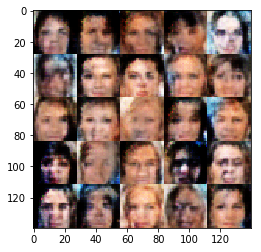

Epoch 1/1... Batch 910... Discriminator Loss: 1.2727... Generator Loss: 0.7844
Epoch 1/1... Batch 920... Discriminator Loss: 1.3315... Generator Loss: 0.6744
Epoch 1/1... Batch 930... Discriminator Loss: 1.3749... Generator Loss: 1.1328
Epoch 1/1... Batch 940... Discriminator Loss: 1.2008... Generator Loss: 1.0084
Epoch 1/1... Batch 950... Discriminator Loss: 1.7323... Generator Loss: 0.2861
Epoch 1/1... Batch 960... Discriminator Loss: 0.7823... Generator Loss: 0.8862
Epoch 1/1... Batch 970... Discriminator Loss: 1.6115... Generator Loss: 1.5836
Epoch 1/1... Batch 980... Discriminator Loss: 0.7760... Generator Loss: 0.9711
Epoch 1/1... Batch 990... Discriminator Loss: 1.2958... Generator Loss: 1.2651
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0209... Generator Loss: 0.7640


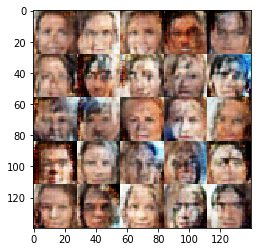

Epoch 1/1... Batch 1010... Discriminator Loss: 1.7174... Generator Loss: 0.2497
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1400... Generator Loss: 1.0682
Epoch 1/1... Batch 1030... Discriminator Loss: 1.1733... Generator Loss: 0.4829
Epoch 1/1... Batch 1040... Discriminator Loss: 1.1695... Generator Loss: 0.4332
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2454... Generator Loss: 0.7403
Epoch 1/1... Batch 1060... Discriminator Loss: 0.7573... Generator Loss: 0.8988
Epoch 1/1... Batch 1070... Discriminator Loss: 1.3342... Generator Loss: 0.8523
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4539... Generator Loss: 0.9537
Epoch 1/1... Batch 1090... Discriminator Loss: 1.7634... Generator Loss: 0.3371
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4176... Generator Loss: 0.6420


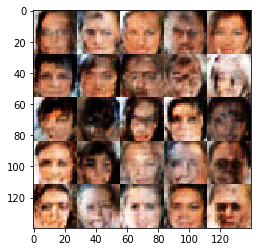

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1042... Generator Loss: 0.6448
Epoch 1/1... Batch 1120... Discriminator Loss: 1.8641... Generator Loss: 0.6015
Epoch 1/1... Batch 1130... Discriminator Loss: 2.0812... Generator Loss: 0.1874
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1022... Generator Loss: 0.6642
Epoch 1/1... Batch 1150... Discriminator Loss: 1.2329... Generator Loss: 0.8371
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2355... Generator Loss: 0.7258
Epoch 1/1... Batch 1170... Discriminator Loss: 1.7204... Generator Loss: 0.3708
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2928... Generator Loss: 1.2647
Epoch 1/1... Batch 1190... Discriminator Loss: 1.4383... Generator Loss: 1.0773
Epoch 1/1... Batch 1200... Discriminator Loss: 1.6686... Generator Loss: 0.3154


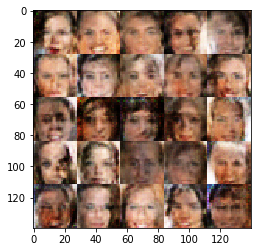

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9210... Generator Loss: 0.9048
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0781... Generator Loss: 0.7510
Epoch 1/1... Batch 1230... Discriminator Loss: 1.1612... Generator Loss: 1.8059
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4052... Generator Loss: 0.9489
Epoch 1/1... Batch 1250... Discriminator Loss: 1.4577... Generator Loss: 0.6770
Epoch 1/1... Batch 1260... Discriminator Loss: 0.9623... Generator Loss: 0.7224
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2649... Generator Loss: 0.6278
Epoch 1/1... Batch 1280... Discriminator Loss: 0.9312... Generator Loss: 0.7570
Epoch 1/1... Batch 1290... Discriminator Loss: 2.4157... Generator Loss: 0.1367
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3415... Generator Loss: 0.6265


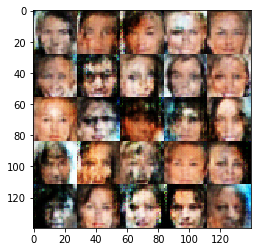

Epoch 1/1... Batch 1310... Discriminator Loss: 1.0403... Generator Loss: 0.7099
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4588... Generator Loss: 1.3885
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1546... Generator Loss: 1.1810
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4268... Generator Loss: 0.5753
Epoch 1/1... Batch 1350... Discriminator Loss: 1.5431... Generator Loss: 0.5604
Epoch 1/1... Batch 1360... Discriminator Loss: 1.7760... Generator Loss: 0.2295
Epoch 1/1... Batch 1370... Discriminator Loss: 1.4320... Generator Loss: 1.0440
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4045... Generator Loss: 0.3750
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2732... Generator Loss: 0.6524
Epoch 1/1... Batch 1400... Discriminator Loss: 1.8598... Generator Loss: 0.5106


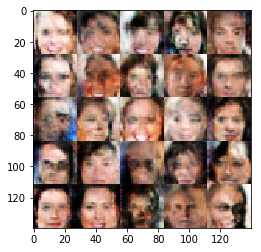

Epoch 1/1... Batch 1410... Discriminator Loss: 1.6005... Generator Loss: 0.5424
Epoch 1/1... Batch 1420... Discriminator Loss: 1.4268... Generator Loss: 0.7914
Epoch 1/1... Batch 1430... Discriminator Loss: 1.4174... Generator Loss: 0.3972
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3127... Generator Loss: 0.7763
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2362... Generator Loss: 0.9116
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2840... Generator Loss: 0.4260
Epoch 1/1... Batch 1470... Discriminator Loss: 0.9471... Generator Loss: 1.0159
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1350... Generator Loss: 0.6715
Epoch 1/1... Batch 1490... Discriminator Loss: 1.5296... Generator Loss: 0.4405
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2734... Generator Loss: 0.4442


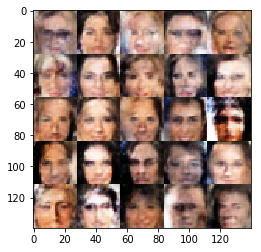

Epoch 1/1... Batch 1510... Discriminator Loss: 1.0932... Generator Loss: 0.9151
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3575... Generator Loss: 0.5064
Epoch 1/1... Batch 1530... Discriminator Loss: 1.5805... Generator Loss: 0.2802
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2301... Generator Loss: 0.7192
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1389... Generator Loss: 0.5327
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3429... Generator Loss: 0.4467
Epoch 1/1... Batch 1570... Discriminator Loss: 1.1525... Generator Loss: 0.6237
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2254... Generator Loss: 1.0486
Epoch 1/1... Batch 1590... Discriminator Loss: 1.3175... Generator Loss: 0.4188
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1046... Generator Loss: 0.8294


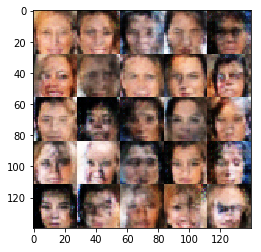

Epoch 1/1... Batch 1610... Discriminator Loss: 1.6123... Generator Loss: 1.3960
Epoch 1/1... Batch 1620... Discriminator Loss: 1.3769... Generator Loss: 0.6307
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2029... Generator Loss: 1.1638
Epoch 1/1... Batch 1640... Discriminator Loss: 1.5138... Generator Loss: 0.4938
Epoch 1/1... Batch 1650... Discriminator Loss: 0.9796... Generator Loss: 0.7012
Epoch 1/1... Batch 1660... Discriminator Loss: 1.6923... Generator Loss: 0.3487
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2476... Generator Loss: 0.9705
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4882... Generator Loss: 0.6005
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2072... Generator Loss: 1.0444
Epoch 1/1... Batch 1700... Discriminator Loss: 0.9859... Generator Loss: 0.6744


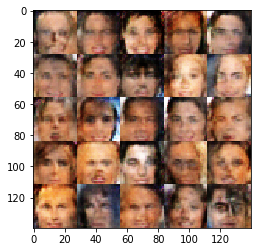

Epoch 1/1... Batch 1710... Discriminator Loss: 1.2801... Generator Loss: 0.5206
Epoch 1/1... Batch 1720... Discriminator Loss: 1.0292... Generator Loss: 0.9435
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1861... Generator Loss: 0.5380
Epoch 1/1... Batch 1740... Discriminator Loss: 1.1277... Generator Loss: 0.6188
Epoch 1/1... Batch 1750... Discriminator Loss: 1.0247... Generator Loss: 0.8122
Epoch 1/1... Batch 1760... Discriminator Loss: 1.0117... Generator Loss: 0.7108
Epoch 1/1... Batch 1770... Discriminator Loss: 1.2109... Generator Loss: 0.6467
Epoch 1/1... Batch 1780... Discriminator Loss: 1.2741... Generator Loss: 0.8356
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1772... Generator Loss: 0.7909
Epoch 1/1... Batch 1800... Discriminator Loss: 1.7434... Generator Loss: 0.3682


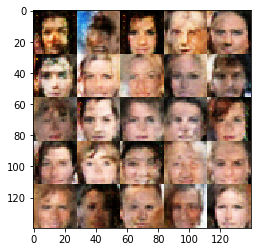

Epoch 1/1... Batch 1810... Discriminator Loss: 1.4385... Generator Loss: 0.5660
Epoch 1/1... Batch 1820... Discriminator Loss: 1.1669... Generator Loss: 0.5154
Epoch 1/1... Batch 1830... Discriminator Loss: 1.4647... Generator Loss: 1.0171
Epoch 1/1... Batch 1840... Discriminator Loss: 1.9205... Generator Loss: 0.2073
Epoch 1/1... Batch 1850... Discriminator Loss: 1.0520... Generator Loss: 0.6938
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1903... Generator Loss: 0.5008
Epoch 1/1... Batch 1870... Discriminator Loss: 1.4612... Generator Loss: 0.4924
Epoch 1/1... Batch 1880... Discriminator Loss: 1.2739... Generator Loss: 1.1539
Epoch 1/1... Batch 1890... Discriminator Loss: 0.9624... Generator Loss: 0.7540
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9655... Generator Loss: 0.6849


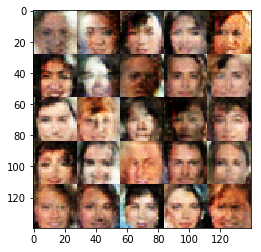

Epoch 1/1... Batch 1910... Discriminator Loss: 1.2353... Generator Loss: 0.6559
Epoch 1/1... Batch 1920... Discriminator Loss: 1.5877... Generator Loss: 0.5963
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1942... Generator Loss: 0.4974
Epoch 1/1... Batch 1940... Discriminator Loss: 1.9454... Generator Loss: 2.4823
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2083... Generator Loss: 0.7722
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1643... Generator Loss: 0.8749
Epoch 1/1... Batch 1970... Discriminator Loss: 1.3365... Generator Loss: 0.9876
Epoch 1/1... Batch 1980... Discriminator Loss: 1.5207... Generator Loss: 0.8689
Epoch 1/1... Batch 1990... Discriminator Loss: 1.0074... Generator Loss: 0.8324
Epoch 1/1... Batch 2000... Discriminator Loss: 1.4197... Generator Loss: 0.5911


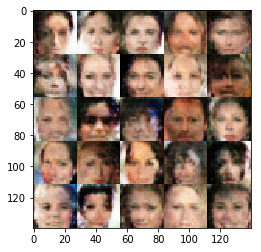

Epoch 1/1... Batch 2010... Discriminator Loss: 1.1753... Generator Loss: 0.6436
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2726... Generator Loss: 1.3067
Epoch 1/1... Batch 2030... Discriminator Loss: 0.9849... Generator Loss: 1.3434
Epoch 1/1... Batch 2040... Discriminator Loss: 1.5069... Generator Loss: 0.3394
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3066... Generator Loss: 0.7880
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1092... Generator Loss: 1.0364
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2045... Generator Loss: 0.8052
Epoch 1/1... Batch 2080... Discriminator Loss: 1.0490... Generator Loss: 0.7391
Epoch 1/1... Batch 2090... Discriminator Loss: 1.4351... Generator Loss: 0.3661
Epoch 1/1... Batch 2100... Discriminator Loss: 1.7702... Generator Loss: 0.5576


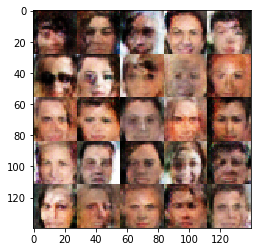

Epoch 1/1... Batch 2110... Discriminator Loss: 1.0635... Generator Loss: 0.9009
Epoch 1/1... Batch 2120... Discriminator Loss: 1.5195... Generator Loss: 0.3162
Epoch 1/1... Batch 2130... Discriminator Loss: 1.4630... Generator Loss: 0.5000
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1772... Generator Loss: 0.7355
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1937... Generator Loss: 0.9050
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4120... Generator Loss: 0.4228
Epoch 1/1... Batch 2170... Discriminator Loss: 2.1456... Generator Loss: 0.1548
Epoch 1/1... Batch 2180... Discriminator Loss: 1.6403... Generator Loss: 0.3900
Epoch 1/1... Batch 2190... Discriminator Loss: 1.4070... Generator Loss: 0.6299
Epoch 1/1... Batch 2200... Discriminator Loss: 1.0912... Generator Loss: 0.8014


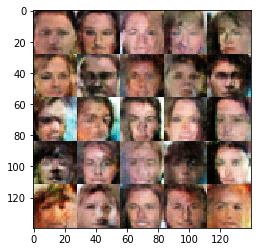

Epoch 1/1... Batch 2210... Discriminator Loss: 1.1963... Generator Loss: 0.8595
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3836... Generator Loss: 0.4184
Epoch 1/1... Batch 2230... Discriminator Loss: 0.9516... Generator Loss: 1.5735
Epoch 1/1... Batch 2240... Discriminator Loss: 1.0819... Generator Loss: 0.6199
Epoch 1/1... Batch 2250... Discriminator Loss: 1.6325... Generator Loss: 0.2753
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2125... Generator Loss: 0.6609
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2208... Generator Loss: 0.6912
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3570... Generator Loss: 0.9177
Epoch 1/1... Batch 2290... Discriminator Loss: 1.3404... Generator Loss: 0.5531
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0938... Generator Loss: 1.4653


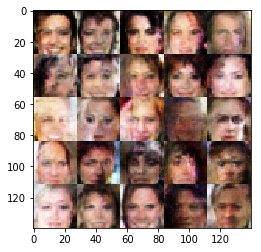

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3243... Generator Loss: 0.6210
Epoch 1/1... Batch 2320... Discriminator Loss: 1.8147... Generator Loss: 0.2353
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1606... Generator Loss: 0.7593
Epoch 1/1... Batch 2340... Discriminator Loss: 1.1607... Generator Loss: 0.5037
Epoch 1/1... Batch 2350... Discriminator Loss: 1.5162... Generator Loss: 0.8105
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1900... Generator Loss: 0.7400
Epoch 1/1... Batch 2370... Discriminator Loss: 1.3217... Generator Loss: 0.4939
Epoch 1/1... Batch 2380... Discriminator Loss: 1.2256... Generator Loss: 0.6081
Epoch 1/1... Batch 2390... Discriminator Loss: 1.7772... Generator Loss: 0.3239
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3230... Generator Loss: 1.0772


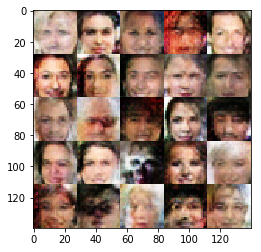

Epoch 1/1... Batch 2410... Discriminator Loss: 1.5952... Generator Loss: 0.3804
Epoch 1/1... Batch 2420... Discriminator Loss: 1.7101... Generator Loss: 1.4740
Epoch 1/1... Batch 2430... Discriminator Loss: 1.6612... Generator Loss: 0.3439
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3258... Generator Loss: 0.6301
Epoch 1/1... Batch 2450... Discriminator Loss: 1.8259... Generator Loss: 1.1848
Epoch 1/1... Batch 2460... Discriminator Loss: 1.0918... Generator Loss: 0.6925
Epoch 1/1... Batch 2470... Discriminator Loss: 1.4236... Generator Loss: 0.5357
Epoch 1/1... Batch 2480... Discriminator Loss: 1.5782... Generator Loss: 0.4767
Epoch 1/1... Batch 2490... Discriminator Loss: 1.4618... Generator Loss: 0.6353
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2933... Generator Loss: 1.4853


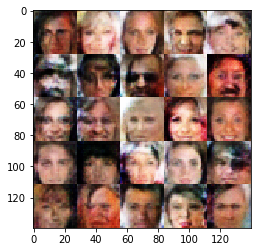

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1255... Generator Loss: 0.7744
Epoch 1/1... Batch 2520... Discriminator Loss: 1.4777... Generator Loss: 0.4002
Epoch 1/1... Batch 2530... Discriminator Loss: 1.1998... Generator Loss: 0.8698
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1807... Generator Loss: 0.5496
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3403... Generator Loss: 0.5189
Epoch 1/1... Batch 2560... Discriminator Loss: 1.5013... Generator Loss: 0.4634
Epoch 1/1... Batch 2570... Discriminator Loss: 1.1916... Generator Loss: 1.3175
Epoch 1/1... Batch 2580... Discriminator Loss: 1.3346... Generator Loss: 0.5348
Epoch 1/1... Batch 2590... Discriminator Loss: 1.0453... Generator Loss: 1.1143
Epoch 1/1... Batch 2600... Discriminator Loss: 1.7197... Generator Loss: 0.2688


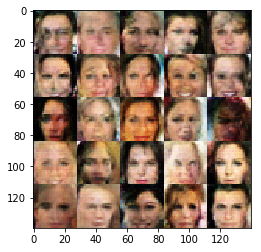

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3191... Generator Loss: 0.6230
Epoch 1/1... Batch 2620... Discriminator Loss: 1.8133... Generator Loss: 0.2711
Epoch 1/1... Batch 2630... Discriminator Loss: 1.5504... Generator Loss: 0.3814
Epoch 1/1... Batch 2640... Discriminator Loss: 0.9412... Generator Loss: 1.0570
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3436... Generator Loss: 0.4427
Epoch 1/1... Batch 2660... Discriminator Loss: 1.2012... Generator Loss: 0.6967
Epoch 1/1... Batch 2670... Discriminator Loss: 1.9064... Generator Loss: 0.2809
Epoch 1/1... Batch 2680... Discriminator Loss: 1.7820... Generator Loss: 0.3080
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2440... Generator Loss: 1.0383
Epoch 1/1... Batch 2700... Discriminator Loss: 1.1316... Generator Loss: 0.7041


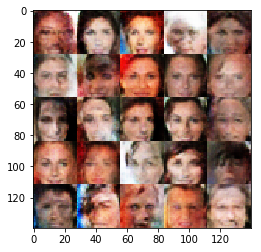

Epoch 1/1... Batch 2710... Discriminator Loss: 1.2355... Generator Loss: 1.1941
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2387... Generator Loss: 0.6202
Epoch 1/1... Batch 2730... Discriminator Loss: 0.7954... Generator Loss: 1.3234
Epoch 1/1... Batch 2740... Discriminator Loss: 1.5059... Generator Loss: 0.4062
Epoch 1/1... Batch 2750... Discriminator Loss: 1.3447... Generator Loss: 0.4738
Epoch 1/1... Batch 2760... Discriminator Loss: 1.1443... Generator Loss: 0.6882
Epoch 1/1... Batch 2770... Discriminator Loss: 0.9282... Generator Loss: 1.1462
Epoch 1/1... Batch 2780... Discriminator Loss: 0.9026... Generator Loss: 0.7602
Epoch 1/1... Batch 2790... Discriminator Loss: 1.0863... Generator Loss: 1.1273
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0868... Generator Loss: 1.0913


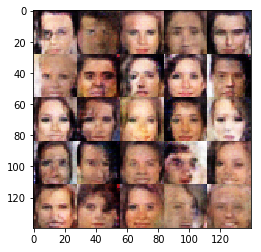

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0436... Generator Loss: 0.6702
Epoch 1/1... Batch 2820... Discriminator Loss: 1.4196... Generator Loss: 0.5755
Epoch 1/1... Batch 2830... Discriminator Loss: 1.0471... Generator Loss: 1.1521
Epoch 1/1... Batch 2840... Discriminator Loss: 1.5506... Generator Loss: 0.3658
Epoch 1/1... Batch 2850... Discriminator Loss: 1.1070... Generator Loss: 0.8364
Epoch 1/1... Batch 2860... Discriminator Loss: 1.7109... Generator Loss: 0.2764
Epoch 1/1... Batch 2870... Discriminator Loss: 1.2026... Generator Loss: 1.2223
Epoch 1/1... Batch 2880... Discriminator Loss: 1.6174... Generator Loss: 0.4066
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1180... Generator Loss: 0.5702
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4276... Generator Loss: 0.5254


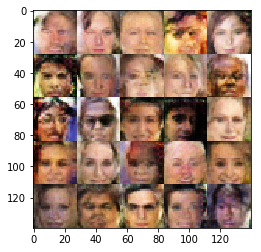

Epoch 1/1... Batch 2910... Discriminator Loss: 1.1158... Generator Loss: 1.8717
Epoch 1/1... Batch 2920... Discriminator Loss: 1.6094... Generator Loss: 0.3429
Epoch 1/1... Batch 2930... Discriminator Loss: 1.3380... Generator Loss: 0.5192
Epoch 1/1... Batch 2940... Discriminator Loss: 0.9937... Generator Loss: 1.1889
Epoch 1/1... Batch 2950... Discriminator Loss: 1.3462... Generator Loss: 0.4371
Epoch 1/1... Batch 2960... Discriminator Loss: 1.6980... Generator Loss: 0.3382
Epoch 1/1... Batch 2970... Discriminator Loss: 1.3146... Generator Loss: 0.9452
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1955... Generator Loss: 0.7276
Epoch 1/1... Batch 2990... Discriminator Loss: 1.5291... Generator Loss: 0.3817
Epoch 1/1... Batch 3000... Discriminator Loss: 1.6407... Generator Loss: 0.3481


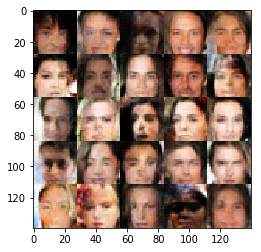

Epoch 1/1... Batch 3010... Discriminator Loss: 1.0912... Generator Loss: 0.6847
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2837... Generator Loss: 0.5494
Epoch 1/1... Batch 3030... Discriminator Loss: 1.6601... Generator Loss: 0.2776
Epoch 1/1... Batch 3040... Discriminator Loss: 1.3354... Generator Loss: 0.6046
Epoch 1/1... Batch 3050... Discriminator Loss: 1.1323... Generator Loss: 1.0607
Epoch 1/1... Batch 3060... Discriminator Loss: 1.6833... Generator Loss: 0.3157
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9880... Generator Loss: 0.8419
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2459... Generator Loss: 0.8692
Epoch 1/1... Batch 3090... Discriminator Loss: 1.2464... Generator Loss: 0.8064
Epoch 1/1... Batch 3100... Discriminator Loss: 1.1968... Generator Loss: 0.5799


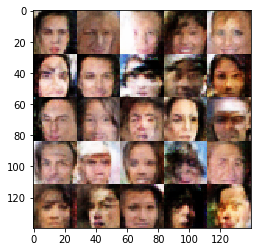

Epoch 1/1... Batch 3110... Discriminator Loss: 1.3051... Generator Loss: 0.7062
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1749... Generator Loss: 0.8204
Epoch 1/1... Batch 3130... Discriminator Loss: 1.1876... Generator Loss: 0.9542
Epoch 1/1... Batch 3140... Discriminator Loss: 1.3726... Generator Loss: 0.5228
Epoch 1/1... Batch 3150... Discriminator Loss: 0.9999... Generator Loss: 0.6809
Epoch 1/1... Batch 3160... Discriminator Loss: 2.2385... Generator Loss: 0.1729
Epoch 1/1... Batch 3170... Discriminator Loss: 1.5217... Generator Loss: 0.4373
Epoch 1/1... Batch 3180... Discriminator Loss: 1.1916... Generator Loss: 0.7438
Epoch 1/1... Batch 3190... Discriminator Loss: 1.5597... Generator Loss: 0.3874
Epoch 1/1... Batch 3200... Discriminator Loss: 1.7989... Generator Loss: 0.2648


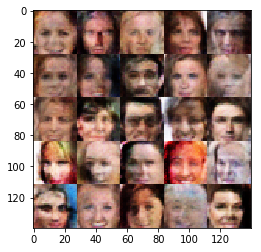

Epoch 1/1... Batch 3210... Discriminator Loss: 1.6241... Generator Loss: 0.4901
Epoch 1/1... Batch 3220... Discriminator Loss: 1.2586... Generator Loss: 0.6254
Epoch 1/1... Batch 3230... Discriminator Loss: 1.2131... Generator Loss: 0.6988
Epoch 1/1... Batch 3240... Discriminator Loss: 1.3807... Generator Loss: 0.4177
Epoch 1/1... Batch 3250... Discriminator Loss: 1.2971... Generator Loss: 0.5612
Epoch 1/1... Batch 3260... Discriminator Loss: 2.1352... Generator Loss: 0.1728
Epoch 1/1... Batch 3270... Discriminator Loss: 1.3322... Generator Loss: 0.5518
Epoch 1/1... Batch 3280... Discriminator Loss: 1.2623... Generator Loss: 0.5035
Epoch 1/1... Batch 3290... Discriminator Loss: 1.2672... Generator Loss: 0.8408
Epoch 1/1... Batch 3300... Discriminator Loss: 1.3840... Generator Loss: 1.6682


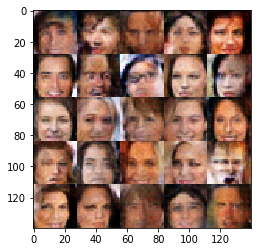

Epoch 1/1... Batch 3310... Discriminator Loss: 1.1558... Generator Loss: 0.5884
Epoch 1/1... Batch 3320... Discriminator Loss: 1.3786... Generator Loss: 0.4194
Epoch 1/1... Batch 3330... Discriminator Loss: 1.2464... Generator Loss: 0.6242
Epoch 1/1... Batch 3340... Discriminator Loss: 1.4523... Generator Loss: 0.7431
Epoch 1/1... Batch 3350... Discriminator Loss: 1.5399... Generator Loss: 0.3265
Epoch 1/1... Batch 3360... Discriminator Loss: 1.3127... Generator Loss: 0.6306
Epoch 1/1... Batch 3370... Discriminator Loss: 1.0907... Generator Loss: 0.7082
Epoch 1/1... Batch 3380... Discriminator Loss: 0.9659... Generator Loss: 0.7836
Epoch 1/1... Batch 3390... Discriminator Loss: 1.1334... Generator Loss: 0.5658
Epoch 1/1... Batch 3400... Discriminator Loss: 0.9610... Generator Loss: 0.6734


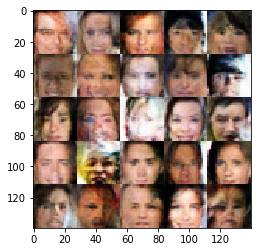

Epoch 1/1... Batch 3410... Discriminator Loss: 1.4688... Generator Loss: 0.8434
Epoch 1/1... Batch 3420... Discriminator Loss: 1.3806... Generator Loss: 0.6401
Epoch 1/1... Batch 3430... Discriminator Loss: 2.0827... Generator Loss: 0.1708
Epoch 1/1... Batch 3440... Discriminator Loss: 1.3650... Generator Loss: 0.6295
Epoch 1/1... Batch 3450... Discriminator Loss: 1.2722... Generator Loss: 0.5364
Epoch 1/1... Batch 3460... Discriminator Loss: 1.1456... Generator Loss: 0.7176
Epoch 1/1... Batch 3470... Discriminator Loss: 1.1680... Generator Loss: 0.6734
Epoch 1/1... Batch 3480... Discriminator Loss: 1.3940... Generator Loss: 0.7064
Epoch 1/1... Batch 3490... Discriminator Loss: 1.1140... Generator Loss: 0.7462
Epoch 1/1... Batch 3500... Discriminator Loss: 1.2108... Generator Loss: 0.6414


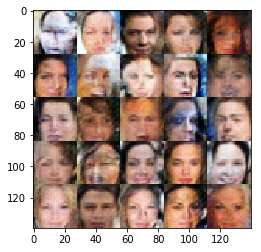

Epoch 1/1... Batch 3510... Discriminator Loss: 1.4821... Generator Loss: 0.3912
Epoch 1/1... Batch 3520... Discriminator Loss: 1.4598... Generator Loss: 0.4263
Epoch 1/1... Batch 3530... Discriminator Loss: 1.3305... Generator Loss: 0.4499
Epoch 1/1... Batch 3540... Discriminator Loss: 1.1411... Generator Loss: 0.8942
Epoch 1/1... Batch 3550... Discriminator Loss: 1.0787... Generator Loss: 1.0555
Epoch 1/1... Batch 3560... Discriminator Loss: 0.7566... Generator Loss: 2.1676
Epoch 1/1... Batch 3570... Discriminator Loss: 1.2175... Generator Loss: 0.5165
Epoch 1/1... Batch 3580... Discriminator Loss: 1.5144... Generator Loss: 0.3602
Epoch 1/1... Batch 3590... Discriminator Loss: 1.6217... Generator Loss: 0.3816
Epoch 1/1... Batch 3600... Discriminator Loss: 1.3638... Generator Loss: 0.8780


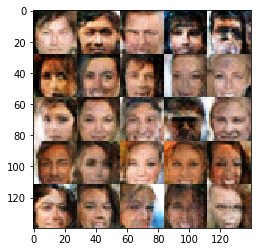

Epoch 1/1... Batch 3610... Discriminator Loss: 0.9634... Generator Loss: 0.7111
Epoch 1/1... Batch 3620... Discriminator Loss: 1.1727... Generator Loss: 1.0802
Epoch 1/1... Batch 3630... Discriminator Loss: 0.9271... Generator Loss: 1.3425
Epoch 1/1... Batch 3640... Discriminator Loss: 1.3222... Generator Loss: 0.8162
Epoch 1/1... Batch 3650... Discriminator Loss: 1.3317... Generator Loss: 0.4648
Epoch 1/1... Batch 3660... Discriminator Loss: 1.5614... Generator Loss: 0.4701
Epoch 1/1... Batch 3670... Discriminator Loss: 0.7655... Generator Loss: 1.1689
Epoch 1/1... Batch 3680... Discriminator Loss: 1.5339... Generator Loss: 0.7762
Epoch 1/1... Batch 3690... Discriminator Loss: 1.3295... Generator Loss: 0.7740
Epoch 1/1... Batch 3700... Discriminator Loss: 1.3447... Generator Loss: 0.4865


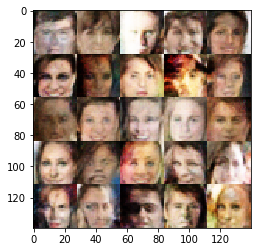

Epoch 1/1... Batch 3710... Discriminator Loss: 1.2004... Generator Loss: 0.6883
Epoch 1/1... Batch 3720... Discriminator Loss: 1.3038... Generator Loss: 0.4818
Epoch 1/1... Batch 3730... Discriminator Loss: 1.5773... Generator Loss: 1.2230
Epoch 1/1... Batch 3740... Discriminator Loss: 0.9965... Generator Loss: 1.1428
Epoch 1/1... Batch 3750... Discriminator Loss: 1.0178... Generator Loss: 0.7604
Epoch 1/1... Batch 3760... Discriminator Loss: 1.6120... Generator Loss: 0.8394
Epoch 1/1... Batch 3770... Discriminator Loss: 1.4076... Generator Loss: 0.4911
Epoch 1/1... Batch 3780... Discriminator Loss: 1.4508... Generator Loss: 1.0984
Epoch 1/1... Batch 3790... Discriminator Loss: 1.1249... Generator Loss: 0.5830
Epoch 1/1... Batch 3800... Discriminator Loss: 1.4598... Generator Loss: 0.7645


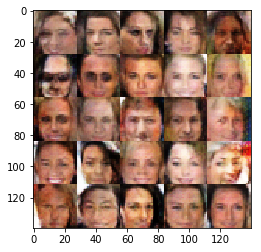

Epoch 1/1... Batch 3810... Discriminator Loss: 1.5132... Generator Loss: 0.4349
Epoch 1/1... Batch 3820... Discriminator Loss: 1.3765... Generator Loss: 0.4528
Epoch 1/1... Batch 3830... Discriminator Loss: 1.2258... Generator Loss: 0.5816
Epoch 1/1... Batch 3840... Discriminator Loss: 0.9318... Generator Loss: 1.0139
Epoch 1/1... Batch 3850... Discriminator Loss: 1.1302... Generator Loss: 0.9028
Epoch 1/1... Batch 3860... Discriminator Loss: 1.2835... Generator Loss: 0.5653
Epoch 1/1... Batch 3870... Discriminator Loss: 1.3861... Generator Loss: 1.0116
Epoch 1/1... Batch 3880... Discriminator Loss: 1.1296... Generator Loss: 0.7096
Epoch 1/1... Batch 3890... Discriminator Loss: 0.8753... Generator Loss: 2.2638
Epoch 1/1... Batch 3900... Discriminator Loss: 0.8947... Generator Loss: 0.9002


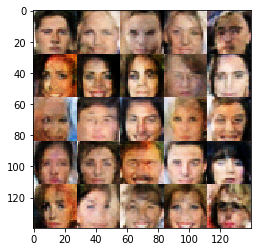

Epoch 1/1... Batch 3910... Discriminator Loss: 1.1477... Generator Loss: 0.5700
Epoch 1/1... Batch 3920... Discriminator Loss: 1.0782... Generator Loss: 0.7757
Epoch 1/1... Batch 3930... Discriminator Loss: 0.7018... Generator Loss: 1.1255
Epoch 1/1... Batch 3940... Discriminator Loss: 1.6893... Generator Loss: 0.2740
Epoch 1/1... Batch 3950... Discriminator Loss: 0.9275... Generator Loss: 0.8191
Epoch 1/1... Batch 3960... Discriminator Loss: 1.7673... Generator Loss: 0.2805
Epoch 1/1... Batch 3970... Discriminator Loss: 1.0051... Generator Loss: 0.6869
Epoch 1/1... Batch 3980... Discriminator Loss: 1.0985... Generator Loss: 0.9815
Epoch 1/1... Batch 3990... Discriminator Loss: 0.9036... Generator Loss: 1.1292
Epoch 1/1... Batch 4000... Discriminator Loss: 0.6962... Generator Loss: 2.6600


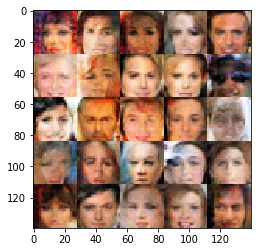

Epoch 1/1... Batch 4010... Discriminator Loss: 0.5426... Generator Loss: 2.0940
Epoch 1/1... Batch 4020... Discriminator Loss: 0.9758... Generator Loss: 3.1295
Epoch 1/1... Batch 4030... Discriminator Loss: 1.5312... Generator Loss: 0.5275
Epoch 1/1... Batch 4040... Discriminator Loss: 1.0498... Generator Loss: 0.8206
Epoch 1/1... Batch 4050... Discriminator Loss: 1.8661... Generator Loss: 1.7775
Epoch 1/1... Batch 4060... Discriminator Loss: 1.8606... Generator Loss: 1.1877
Epoch 1/1... Batch 4070... Discriminator Loss: 0.8220... Generator Loss: 1.2846
Epoch 1/1... Batch 4080... Discriminator Loss: 1.3878... Generator Loss: 0.6204
Epoch 1/1... Batch 4090... Discriminator Loss: 1.5948... Generator Loss: 0.2757
Epoch 1/1... Batch 4100... Discriminator Loss: 1.1244... Generator Loss: 0.7659


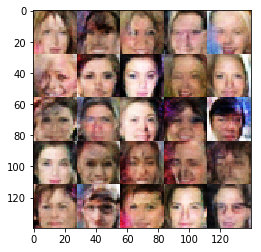

Epoch 1/1... Batch 4110... Discriminator Loss: 1.5537... Generator Loss: 0.3846
Epoch 1/1... Batch 4120... Discriminator Loss: 0.8038... Generator Loss: 0.7843
Epoch 1/1... Batch 4130... Discriminator Loss: 0.6768... Generator Loss: 1.5026
Epoch 1/1... Batch 4140... Discriminator Loss: 1.5464... Generator Loss: 0.3617
Epoch 1/1... Batch 4150... Discriminator Loss: 1.4952... Generator Loss: 0.3740
Epoch 1/1... Batch 4160... Discriminator Loss: 1.2290... Generator Loss: 0.5022
Epoch 1/1... Batch 4170... Discriminator Loss: 1.0915... Generator Loss: 0.6127
Epoch 1/1... Batch 4180... Discriminator Loss: 1.2624... Generator Loss: 1.7813
Epoch 1/1... Batch 4190... Discriminator Loss: 1.4069... Generator Loss: 0.5793
Epoch 1/1... Batch 4200... Discriminator Loss: 0.8043... Generator Loss: 1.0972


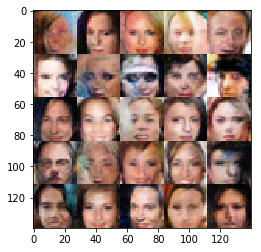

Epoch 1/1... Batch 4210... Discriminator Loss: 1.8196... Generator Loss: 0.2721
Epoch 1/1... Batch 4220... Discriminator Loss: 1.3692... Generator Loss: 0.5979
Epoch 1/1... Batch 4230... Discriminator Loss: 1.3482... Generator Loss: 0.6305
Epoch 1/1... Batch 4240... Discriminator Loss: 1.2070... Generator Loss: 0.9082
Epoch 1/1... Batch 4250... Discriminator Loss: 1.0314... Generator Loss: 0.9468
Epoch 1/1... Batch 4260... Discriminator Loss: 0.7867... Generator Loss: 1.1536
Epoch 1/1... Batch 4270... Discriminator Loss: 0.9511... Generator Loss: 0.9380
Epoch 1/1... Batch 4280... Discriminator Loss: 1.3445... Generator Loss: 0.8387
Epoch 1/1... Batch 4290... Discriminator Loss: 0.9869... Generator Loss: 0.9440
Epoch 1/1... Batch 4300... Discriminator Loss: 1.2000... Generator Loss: 0.5747


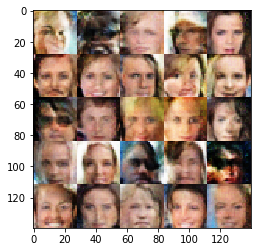

Epoch 1/1... Batch 4310... Discriminator Loss: 1.6399... Generator Loss: 0.6856
Epoch 1/1... Batch 4320... Discriminator Loss: 1.0628... Generator Loss: 0.7608
Epoch 1/1... Batch 4330... Discriminator Loss: 1.0962... Generator Loss: 0.5341
Epoch 1/1... Batch 4340... Discriminator Loss: 1.5460... Generator Loss: 0.5176
Epoch 1/1... Batch 4350... Discriminator Loss: 1.2459... Generator Loss: 0.5667
Epoch 1/1... Batch 4360... Discriminator Loss: 1.3158... Generator Loss: 0.5051
Epoch 1/1... Batch 4370... Discriminator Loss: 0.8801... Generator Loss: 0.7341
Epoch 1/1... Batch 4380... Discriminator Loss: 1.5943... Generator Loss: 0.8249
Epoch 1/1... Batch 4390... Discriminator Loss: 1.0532... Generator Loss: 1.7962
Epoch 1/1... Batch 4400... Discriminator Loss: 1.5492... Generator Loss: 0.5339


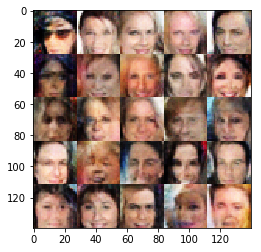

Epoch 1/1... Batch 4410... Discriminator Loss: 1.0295... Generator Loss: 0.6314
Epoch 1/1... Batch 4420... Discriminator Loss: 1.1717... Generator Loss: 0.7711
Epoch 1/1... Batch 4430... Discriminator Loss: 1.7974... Generator Loss: 0.8637
Epoch 1/1... Batch 4440... Discriminator Loss: 0.9169... Generator Loss: 1.1287
Epoch 1/1... Batch 4450... Discriminator Loss: 1.3145... Generator Loss: 0.4947
Epoch 1/1... Batch 4460... Discriminator Loss: 1.4125... Generator Loss: 0.4561
Epoch 1/1... Batch 4470... Discriminator Loss: 1.7808... Generator Loss: 0.2610
Epoch 1/1... Batch 4480... Discriminator Loss: 1.0112... Generator Loss: 0.7481
Epoch 1/1... Batch 4490... Discriminator Loss: 0.8438... Generator Loss: 1.1528
Epoch 1/1... Batch 4500... Discriminator Loss: 0.8718... Generator Loss: 1.0408


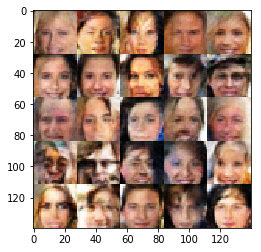

Epoch 1/1... Batch 4510... Discriminator Loss: 1.5824... Generator Loss: 1.0934
Epoch 1/1... Batch 4520... Discriminator Loss: 1.8042... Generator Loss: 0.2667
Epoch 1/1... Batch 4530... Discriminator Loss: 1.2901... Generator Loss: 0.8950
Epoch 1/1... Batch 4540... Discriminator Loss: 1.2624... Generator Loss: 0.4688
Epoch 1/1... Batch 4550... Discriminator Loss: 1.7445... Generator Loss: 0.2526
Epoch 1/1... Batch 4560... Discriminator Loss: 1.7942... Generator Loss: 0.3105
Epoch 1/1... Batch 4570... Discriminator Loss: 1.4690... Generator Loss: 0.3815
Epoch 1/1... Batch 4580... Discriminator Loss: 1.3915... Generator Loss: 0.5881
Epoch 1/1... Batch 4590... Discriminator Loss: 1.0060... Generator Loss: 0.7497
Epoch 1/1... Batch 4600... Discriminator Loss: 1.7984... Generator Loss: 0.2876


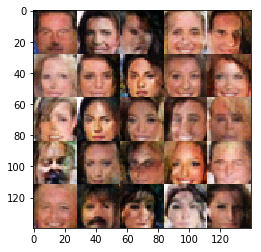

Epoch 1/1... Batch 4610... Discriminator Loss: 1.5491... Generator Loss: 1.0940
Epoch 1/1... Batch 4620... Discriminator Loss: 1.2479... Generator Loss: 0.5706
Epoch 1/1... Batch 4630... Discriminator Loss: 1.2526... Generator Loss: 0.6218
Epoch 1/1... Batch 4640... Discriminator Loss: 1.5350... Generator Loss: 0.4480
Epoch 1/1... Batch 4650... Discriminator Loss: 1.4418... Generator Loss: 0.4226
Epoch 1/1... Batch 4660... Discriminator Loss: 1.4596... Generator Loss: 0.4527
Epoch 1/1... Batch 4670... Discriminator Loss: 0.8916... Generator Loss: 0.8313
Epoch 1/1... Batch 4680... Discriminator Loss: 1.0769... Generator Loss: 0.9012
Epoch 1/1... Batch 4690... Discriminator Loss: 1.2673... Generator Loss: 0.5304
Epoch 1/1... Batch 4700... Discriminator Loss: 1.1694... Generator Loss: 0.5586


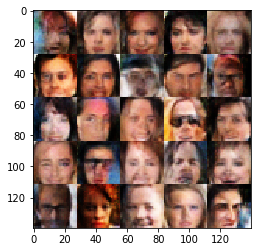

Epoch 1/1... Batch 4710... Discriminator Loss: 1.5186... Generator Loss: 0.4542
Epoch 1/1... Batch 4720... Discriminator Loss: 1.2559... Generator Loss: 1.0237
Epoch 1/1... Batch 4730... Discriminator Loss: 1.4832... Generator Loss: 1.1643
Epoch 1/1... Batch 4740... Discriminator Loss: 1.1169... Generator Loss: 0.6398
Epoch 1/1... Batch 4750... Discriminator Loss: 1.2498... Generator Loss: 0.7411
Epoch 1/1... Batch 4760... Discriminator Loss: 1.2565... Generator Loss: 0.5600
Epoch 1/1... Batch 4770... Discriminator Loss: 1.2839... Generator Loss: 0.8506
Epoch 1/1... Batch 4780... Discriminator Loss: 1.3625... Generator Loss: 0.4462
Epoch 1/1... Batch 4790... Discriminator Loss: 1.5237... Generator Loss: 0.3366
Epoch 1/1... Batch 4800... Discriminator Loss: 1.3283... Generator Loss: 0.4667


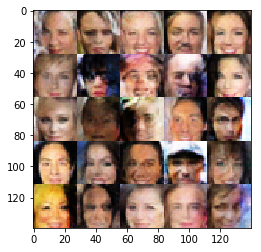

Epoch 1/1... Batch 4810... Discriminator Loss: 1.3966... Generator Loss: 0.5296
Epoch 1/1... Batch 4820... Discriminator Loss: 1.3328... Generator Loss: 0.5534
Epoch 1/1... Batch 4830... Discriminator Loss: 1.0513... Generator Loss: 0.7326
Epoch 1/1... Batch 4840... Discriminator Loss: 1.0578... Generator Loss: 0.7443
Epoch 1/1... Batch 4850... Discriminator Loss: 1.1989... Generator Loss: 0.6439
Epoch 1/1... Batch 4860... Discriminator Loss: 1.1732... Generator Loss: 0.5655
Epoch 1/1... Batch 4870... Discriminator Loss: 1.2842... Generator Loss: 0.8076
Epoch 1/1... Batch 4880... Discriminator Loss: 1.3172... Generator Loss: 0.8734
Epoch 1/1... Batch 4890... Discriminator Loss: 1.6309... Generator Loss: 0.4134
Epoch 1/1... Batch 4900... Discriminator Loss: 1.7298... Generator Loss: 0.3268


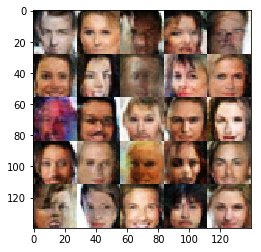

Epoch 1/1... Batch 4910... Discriminator Loss: 1.6884... Generator Loss: 0.2927
Epoch 1/1... Batch 4920... Discriminator Loss: 1.3864... Generator Loss: 0.5735
Epoch 1/1... Batch 4930... Discriminator Loss: 1.3810... Generator Loss: 0.4814
Epoch 1/1... Batch 4940... Discriminator Loss: 1.1711... Generator Loss: 0.5260
Epoch 1/1... Batch 4950... Discriminator Loss: 1.7215... Generator Loss: 0.2795
Epoch 1/1... Batch 4960... Discriminator Loss: 0.9866... Generator Loss: 0.7553
Epoch 1/1... Batch 4970... Discriminator Loss: 1.9517... Generator Loss: 1.1524
Epoch 1/1... Batch 4980... Discriminator Loss: 1.1754... Generator Loss: 0.6044
Epoch 1/1... Batch 4990... Discriminator Loss: 1.2720... Generator Loss: 0.5923
Epoch 1/1... Batch 5000... Discriminator Loss: 0.7813... Generator Loss: 1.0619


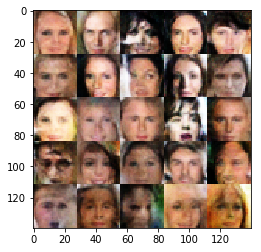

Epoch 1/1... Batch 5010... Discriminator Loss: 1.8854... Generator Loss: 0.2667
Epoch 1/1... Batch 5020... Discriminator Loss: 1.5550... Generator Loss: 0.4250
Epoch 1/1... Batch 5030... Discriminator Loss: 1.2097... Generator Loss: 0.7563
Epoch 1/1... Batch 5040... Discriminator Loss: 0.8945... Generator Loss: 1.0815
Epoch 1/1... Batch 5050... Discriminator Loss: 1.3859... Generator Loss: 0.8183
Epoch 1/1... Batch 5060... Discriminator Loss: 1.4228... Generator Loss: 0.6119
Epoch 1/1... Batch 5070... Discriminator Loss: 1.8088... Generator Loss: 0.2690
Epoch 1/1... Batch 5080... Discriminator Loss: 1.4263... Generator Loss: 0.4283
Epoch 1/1... Batch 5090... Discriminator Loss: 0.9253... Generator Loss: 0.9856
Epoch 1/1... Batch 5100... Discriminator Loss: 1.3827... Generator Loss: 0.5729


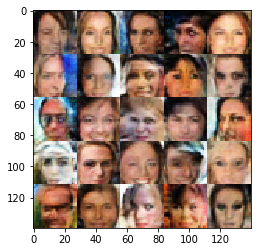

Epoch 1/1... Batch 5110... Discriminator Loss: 1.7818... Generator Loss: 1.4339
Epoch 1/1... Batch 5120... Discriminator Loss: 1.1919... Generator Loss: 2.0219
Epoch 1/1... Batch 5130... Discriminator Loss: 1.5414... Generator Loss: 0.5118
Epoch 1/1... Batch 5140... Discriminator Loss: 0.9787... Generator Loss: 0.7833
Epoch 1/1... Batch 5150... Discriminator Loss: 1.1262... Generator Loss: 0.7992
Epoch 1/1... Batch 5160... Discriminator Loss: 1.2826... Generator Loss: 0.4719
Epoch 1/1... Batch 5170... Discriminator Loss: 1.0403... Generator Loss: 0.6980
Epoch 1/1... Batch 5180... Discriminator Loss: 1.1640... Generator Loss: 0.6749
Epoch 1/1... Batch 5190... Discriminator Loss: 1.2057... Generator Loss: 0.5270
Epoch 1/1... Batch 5200... Discriminator Loss: 1.1592... Generator Loss: 0.5927


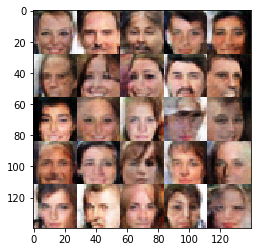

Epoch 1/1... Batch 5210... Discriminator Loss: 1.1702... Generator Loss: 1.0767
Epoch 1/1... Batch 5220... Discriminator Loss: 1.1554... Generator Loss: 0.6844
Epoch 1/1... Batch 5230... Discriminator Loss: 1.4935... Generator Loss: 0.3334
Epoch 1/1... Batch 5240... Discriminator Loss: 1.3628... Generator Loss: 0.4850
Epoch 1/1... Batch 5250... Discriminator Loss: 1.5217... Generator Loss: 0.4131
Epoch 1/1... Batch 5260... Discriminator Loss: 1.5401... Generator Loss: 0.5466
Epoch 1/1... Batch 5270... Discriminator Loss: 1.8480... Generator Loss: 0.2873
Epoch 1/1... Batch 5280... Discriminator Loss: 1.8303... Generator Loss: 0.2436
Epoch 1/1... Batch 5290... Discriminator Loss: 1.4989... Generator Loss: 0.3566
Epoch 1/1... Batch 5300... Discriminator Loss: 1.0658... Generator Loss: 1.1454


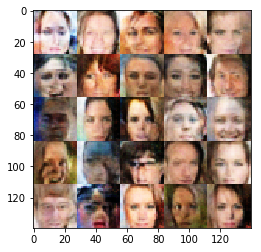

Epoch 1/1... Batch 5310... Discriminator Loss: 1.1890... Generator Loss: 0.5374
Epoch 1/1... Batch 5320... Discriminator Loss: 1.4091... Generator Loss: 0.4213
Epoch 1/1... Batch 5330... Discriminator Loss: 1.0829... Generator Loss: 1.0430
Epoch 1/1... Batch 5340... Discriminator Loss: 1.0162... Generator Loss: 0.8479
Epoch 1/1... Batch 5350... Discriminator Loss: 1.4929... Generator Loss: 0.3550
Epoch 1/1... Batch 5360... Discriminator Loss: 1.3855... Generator Loss: 1.9045
Epoch 1/1... Batch 5370... Discriminator Loss: 1.1020... Generator Loss: 0.9642
Epoch 1/1... Batch 5380... Discriminator Loss: 1.0730... Generator Loss: 0.6370
Epoch 1/1... Batch 5390... Discriminator Loss: 1.0836... Generator Loss: 0.9303
Epoch 1/1... Batch 5400... Discriminator Loss: 1.5151... Generator Loss: 0.3597


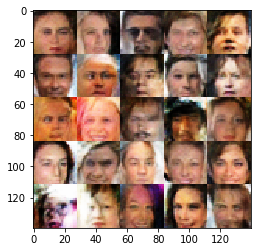

Epoch 1/1... Batch 5410... Discriminator Loss: 1.0622... Generator Loss: 0.6433
Epoch 1/1... Batch 5420... Discriminator Loss: 1.4285... Generator Loss: 0.8308
Epoch 1/1... Batch 5430... Discriminator Loss: 1.5800... Generator Loss: 0.3385
Epoch 1/1... Batch 5440... Discriminator Loss: 1.1200... Generator Loss: 0.9089
Epoch 1/1... Batch 5450... Discriminator Loss: 1.3676... Generator Loss: 0.4152
Epoch 1/1... Batch 5460... Discriminator Loss: 1.2767... Generator Loss: 0.5714
Epoch 1/1... Batch 5470... Discriminator Loss: 1.2571... Generator Loss: 0.5345
Epoch 1/1... Batch 5480... Discriminator Loss: 0.8119... Generator Loss: 1.1222
Epoch 1/1... Batch 5490... Discriminator Loss: 0.9909... Generator Loss: 0.7399
Epoch 1/1... Batch 5500... Discriminator Loss: 1.1356... Generator Loss: 1.4684


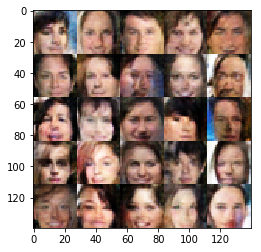

Epoch 1/1... Batch 5510... Discriminator Loss: 0.8309... Generator Loss: 1.2758
Epoch 1/1... Batch 5520... Discriminator Loss: 1.3920... Generator Loss: 0.6649
Epoch 1/1... Batch 5530... Discriminator Loss: 2.3600... Generator Loss: 0.1411
Epoch 1/1... Batch 5540... Discriminator Loss: 1.4424... Generator Loss: 0.4874
Epoch 1/1... Batch 5550... Discriminator Loss: 1.3031... Generator Loss: 0.6867
Epoch 1/1... Batch 5560... Discriminator Loss: 1.1709... Generator Loss: 0.6310
Epoch 1/1... Batch 5570... Discriminator Loss: 1.6889... Generator Loss: 0.3127
Epoch 1/1... Batch 5580... Discriminator Loss: 1.1278... Generator Loss: 0.8339
Epoch 1/1... Batch 5590... Discriminator Loss: 1.7246... Generator Loss: 0.2923
Epoch 1/1... Batch 5600... Discriminator Loss: 1.2053... Generator Loss: 0.5768


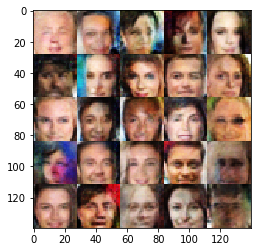

Epoch 1/1... Batch 5610... Discriminator Loss: 1.2852... Generator Loss: 0.4903
Epoch 1/1... Batch 5620... Discriminator Loss: 1.5029... Generator Loss: 0.3816
Epoch 1/1... Batch 5630... Discriminator Loss: 1.2002... Generator Loss: 0.6303
Epoch 1/1... Batch 5640... Discriminator Loss: 1.2125... Generator Loss: 0.5186
Epoch 1/1... Batch 5650... Discriminator Loss: 0.8408... Generator Loss: 1.1835
Epoch 1/1... Batch 5660... Discriminator Loss: 1.4730... Generator Loss: 0.4843
Epoch 1/1... Batch 5670... Discriminator Loss: 0.6106... Generator Loss: 1.9283
Epoch 1/1... Batch 5680... Discriminator Loss: 1.4857... Generator Loss: 0.4050
Epoch 1/1... Batch 5690... Discriminator Loss: 3.4288... Generator Loss: 0.0427
Epoch 1/1... Batch 5700... Discriminator Loss: 0.9001... Generator Loss: 1.0371


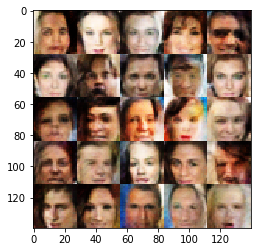

Epoch 1/1... Batch 5710... Discriminator Loss: 0.9315... Generator Loss: 0.8392
Epoch 1/1... Batch 5720... Discriminator Loss: 1.1709... Generator Loss: 0.5995
Epoch 1/1... Batch 5730... Discriminator Loss: 1.0138... Generator Loss: 0.6311
Epoch 1/1... Batch 5740... Discriminator Loss: 1.2098... Generator Loss: 0.8667
Epoch 1/1... Batch 5750... Discriminator Loss: 1.5280... Generator Loss: 0.4023
Epoch 1/1... Batch 5760... Discriminator Loss: 1.0244... Generator Loss: 0.6354
Epoch 1/1... Batch 5770... Discriminator Loss: 1.2990... Generator Loss: 0.5171
Epoch 1/1... Batch 5780... Discriminator Loss: 0.9749... Generator Loss: 0.8903
Epoch 1/1... Batch 5790... Discriminator Loss: 1.3180... Generator Loss: 0.5244
Epoch 1/1... Batch 5800... Discriminator Loss: 1.1429... Generator Loss: 0.5747


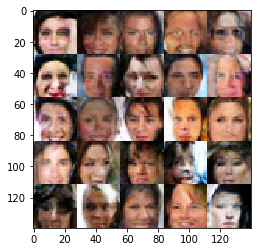

Epoch 1/1... Batch 5810... Discriminator Loss: 1.3593... Generator Loss: 0.3753
Epoch 1/1... Batch 5820... Discriminator Loss: 1.2662... Generator Loss: 0.5518
Epoch 1/1... Batch 5830... Discriminator Loss: 1.1363... Generator Loss: 1.5015
Epoch 1/1... Batch 5840... Discriminator Loss: 1.2540... Generator Loss: 0.5008
Epoch 1/1... Batch 5850... Discriminator Loss: 1.0511... Generator Loss: 0.8024
Epoch 1/1... Batch 5860... Discriminator Loss: 1.2673... Generator Loss: 0.6067
Epoch 1/1... Batch 5870... Discriminator Loss: 1.1956... Generator Loss: 0.4945
Epoch 1/1... Batch 5880... Discriminator Loss: 1.2932... Generator Loss: 0.9255
Epoch 1/1... Batch 5890... Discriminator Loss: 0.6117... Generator Loss: 1.6665
Epoch 1/1... Batch 5900... Discriminator Loss: 1.3197... Generator Loss: 0.4357


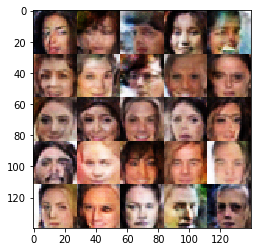

Epoch 1/1... Batch 5910... Discriminator Loss: 1.5788... Generator Loss: 0.3114
Epoch 1/1... Batch 5920... Discriminator Loss: 1.0127... Generator Loss: 1.1611
Epoch 1/1... Batch 5930... Discriminator Loss: 1.2087... Generator Loss: 0.5372
Epoch 1/1... Batch 5940... Discriminator Loss: 1.4681... Generator Loss: 0.3893
Epoch 1/1... Batch 5950... Discriminator Loss: 0.9045... Generator Loss: 1.4121
Epoch 1/1... Batch 5960... Discriminator Loss: 1.5341... Generator Loss: 0.3481
Epoch 1/1... Batch 5970... Discriminator Loss: 1.1337... Generator Loss: 0.6046
Epoch 1/1... Batch 5980... Discriminator Loss: 1.1258... Generator Loss: 0.4754
Epoch 1/1... Batch 5990... Discriminator Loss: 0.9844... Generator Loss: 0.9130
Epoch 1/1... Batch 6000... Discriminator Loss: 1.0936... Generator Loss: 0.7856


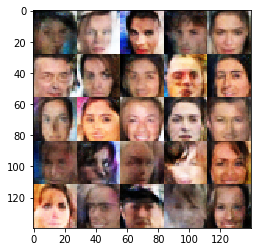

Epoch 1/1... Batch 6010... Discriminator Loss: 0.9884... Generator Loss: 0.6610
Epoch 1/1... Batch 6020... Discriminator Loss: 1.4997... Generator Loss: 0.3908
Epoch 1/1... Batch 6030... Discriminator Loss: 1.4961... Generator Loss: 0.9172
Epoch 1/1... Batch 6040... Discriminator Loss: 0.7123... Generator Loss: 1.5452
Epoch 1/1... Batch 6050... Discriminator Loss: 1.5905... Generator Loss: 0.4992
Epoch 1/1... Batch 6060... Discriminator Loss: 1.4941... Generator Loss: 0.7549
Epoch 1/1... Batch 6070... Discriminator Loss: 1.1759... Generator Loss: 0.6930
Epoch 1/1... Batch 6080... Discriminator Loss: 1.2371... Generator Loss: 0.5966
Epoch 1/1... Batch 6090... Discriminator Loss: 1.3155... Generator Loss: 0.4986
Epoch 1/1... Batch 6100... Discriminator Loss: 0.5007... Generator Loss: 1.5828


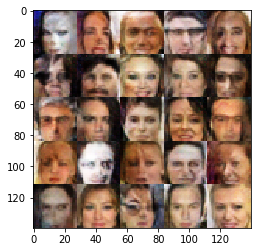

Epoch 1/1... Batch 6110... Discriminator Loss: 0.8677... Generator Loss: 0.9149
Epoch 1/1... Batch 6120... Discriminator Loss: 0.9232... Generator Loss: 0.6943
Epoch 1/1... Batch 6130... Discriminator Loss: 1.6970... Generator Loss: 0.3553
Epoch 1/1... Batch 6140... Discriminator Loss: 1.0455... Generator Loss: 0.7419
Epoch 1/1... Batch 6150... Discriminator Loss: 1.1285... Generator Loss: 0.6622
Epoch 1/1... Batch 6160... Discriminator Loss: 1.2000... Generator Loss: 1.0469
Epoch 1/1... Batch 6170... Discriminator Loss: 1.2485... Generator Loss: 0.5821
Epoch 1/1... Batch 6180... Discriminator Loss: 1.3375... Generator Loss: 0.7784
Epoch 1/1... Batch 6190... Discriminator Loss: 1.2883... Generator Loss: 0.4520
Epoch 1/1... Batch 6200... Discriminator Loss: 1.0635... Generator Loss: 0.6222


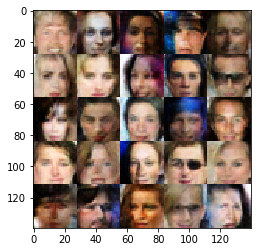

Epoch 1/1... Batch 6210... Discriminator Loss: 0.6509... Generator Loss: 1.6060
Epoch 1/1... Batch 6220... Discriminator Loss: 2.2373... Generator Loss: 0.1780
Epoch 1/1... Batch 6230... Discriminator Loss: 0.8040... Generator Loss: 1.3954
Epoch 1/1... Batch 6240... Discriminator Loss: 1.3664... Generator Loss: 0.7687
Epoch 1/1... Batch 6250... Discriminator Loss: 1.1926... Generator Loss: 0.4843
Epoch 1/1... Batch 6260... Discriminator Loss: 0.9388... Generator Loss: 0.8847
Epoch 1/1... Batch 6270... Discriminator Loss: 1.7373... Generator Loss: 0.2494
Epoch 1/1... Batch 6280... Discriminator Loss: 1.9325... Generator Loss: 0.2501
Epoch 1/1... Batch 6290... Discriminator Loss: 1.8429... Generator Loss: 0.2501
Epoch 1/1... Batch 6300... Discriminator Loss: 1.0119... Generator Loss: 0.8740


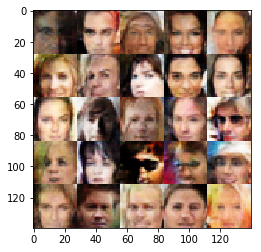

Epoch 1/1... Batch 6310... Discriminator Loss: 1.2058... Generator Loss: 0.6231
Epoch 1/1... Batch 6320... Discriminator Loss: 1.0461... Generator Loss: 1.2560
Epoch 1/1... Batch 6330... Discriminator Loss: 0.7939... Generator Loss: 1.5338


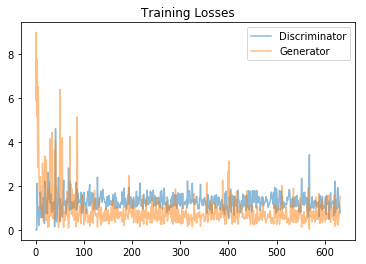

In [27]:
batch_size = 32
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.